In [1]:
# import 
import pandas as pd
import numpy as np
from scipy import interpolate

import matplotlib.pyplot as plt
from matplotlib import animation
import matplotlib.cm as cm
import seaborn as sns

import os, glob, joblib
from tqdm import tqdm
from datetime import datetime
import re

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score ,roc_curve, recall_score, precision_score, f1_score
from sklearn.model_selection import train_test_split

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
file_path = glob.glob("klarfsample_v2/*.001")

print(len(file_path))

210


In [4]:
# 실행할 때마다 한 줄씩 읽어오기
# readlines()로 한번에 시도하면, 용량이 큰 파일의 경우엔 out of memory 가능성.

def readfile(file_path):
    readlines = []
    with open(file_path, 'r') as f:
        i = 1
        while True:
            line = f.readline()
            if not line:
                break
            line = str(i) + ' ' + line
            readlines.append(line.strip('\n').strip(';').split(' '))
            i += 1    
    return readlines

In [5]:
readfile(file_path[0])

[['1', 'FileVersion', '1', '1'],
 ['2', 'FileTimestamp', '02-06-23', '12:05:34'],
 ['3', 'TiffSpec', '6.0', 'G', 'R'],
 ['4',
  'InspectionStationID',
  '"ADVANCED',
  'TECHNOLOGY',
  'INC"',
  '"M08AWD10"',
  '"M08AWD10"'],
 ['5', 'SampleType', 'WAFER'],
 ['6', 'ResultTimestamp', '02-06-23', '12:05:30'],
 ['7', 'LotID', '"TDAJL02T"'],
 ['8', 'SampleSize', '1', '300'],
 ['9', 'DeviceID', '"TDAJL02T"'],
 ['10', 'SetupID', '"TDAS_REFLOW_INSP3"', '02-06-23', '12:05:30'],
 ['11', 'StepID', '"WAFER', 'REFLOW', 'INSP3"'],
 ['12', 'SampleOrientationMarkType', 'NOTCH'],
 ['13', 'OrientationMarkLocation', 'DOWN'],
 ['14', 'TiffFilename', 'TDAS_REFLOW_INSP3_TDAJL02T_00-10.tif'],
 ['15', 'DiePitch', '9.303643e+003', '8.175569e+003'],
 ['16', 'DieOrigin', '0.000000e+000', '0.000000e+000'],
 ['17', 'WaferID', '"10"'],
 ['18', 'Slot', '10'],
 ['19', 'SampleCenterLocation', '9.303643e+003', '4.087785e+003'],
 ['20', 'InspectionTest', '1'],
 ['21', 'SampleTestPlan', '668'],
 ['22', '-1', '16'],
 ['23'

In [6]:
# KLARF file로부터 데이터 parsing
temp_df = pd.DataFrame()
fname = []
for i, fp in enumerate(file_path):
    dict_klarf = {}
    for line in readfile(fp):
        if not line[1].lstrip('-').isnumeric():
            dict_klarf[line[1]] = ' '.join(line[2:])
    fname.append(os.path.split(fp)[1].split('.')[0])
    temp = pd.DataFrame(dict_klarf, index=[i])
    temp_df = pd.concat([temp_df, temp])

temp_df.columns = temp_df.columns.str.lower()
temp_df['filename'] = fname
cols = ['filename']
cols.extend(temp_df.columns[:-1])

temp_df = temp_df[cols]
temp_df.head(3)

,filename,fileversion,filetimestamp,tiffspec,inspectionstationid,sampletype,resulttimestamp,lotid,samplesize,deviceid,...,slot,samplecenterlocation,inspectiontest,sampletestplan,areapertest,defectrecordspec,defectlist,summaryspec,summarylist,endoffile
0,TDAS_REFLOW_INSP3_TDAJL02T_00-10,1 1,02-06-23 12:05:34,6.0 G R,"""ADVANCED TECHNOLOGY INC"" ""M08AWD10"" ""M08AWD10""",WAFER,02-06-23 12:05:30,"""TDAJL02T""",1 300,"""TDAJL02T""",...,10,9.303643e+003 4.087785e+003,1,668,5.080980e+010,17 DEFECTID XREL YREL XINDEX YINDEX XSIZE YSIZ...,,5 TESTNO NDEFECT DEFDENSITY NDIE NDEFDIE,,
1,TAGS_REFLOW_INSP3_TAGHX17T_00-09,1 1,12-17-22 15:08:47,6.0 G R,"""ADVANCED TECHNOLOGY INC"" ""M08AWD10"" ""M08AWD10""",WAFER,12-17-22 15:08:43,"""TAGHX17T""",1 300,"""TAGHX17T""",...,9,3.724062e+003 7.146985e+003,1,1001,5.328486e+010,17 DEFECTID XREL YREL XINDEX YINDEX XSIZE YSIZ...,,5 TESTNO NDEFECT DEFDENSITY NDIE NDEFDIE,,
2,TDAS_REFLOW_INSP3_TDAJN10T_00-10,1 1,02-06-23 08:29:30,6.0 G R,"""ADVANCED TECHNOLOGY INC"" ""M08AWD10"" ""M08AWD10""",WAFER,02-06-23 08:29:25,"""TDAJN10T""",1 300,"""TDAJN10T""",...,10,9.303643e+003 4.087785e+003,1,645,4.906036e+010,17 DEFECTID XREL YREL XINDEX YINDEX XSIZE YSIZ...,,5 TESTNO NDEFECT DEFDENSITY NDIE NDEFDIE,,


In [7]:
selectCols = [
    "filename",
    "filetimestamp",
    "inspectionstationid",
    "lotid",
    "deviceid",
    "setupid",
    "stepid",
    "tifffilename",
    "waferid",
    "slot"
    ]
# 특정 columns만 추출
temp_df = temp_df[selectCols]

In [8]:
# column 비교 후 제거 함수
# 보존할 column = col1
# 제거할 column = col2
def eliminate(df, col1, col2):
    '''
    col1: 남길 컬럼
    col2: 제거할 컬럼
    '''
    if df[df[col1] != df[col2]].size == 0:
        df.drop(columns=col2, inplace=True)
        print(f'"{col2}" Column 제거됨.')
    return df

In [9]:
# temp_df의 FileTimestamp를 datetime형으로 변환
# 현재 %m-%d-%y %H:%M:%S 형태로 되어있음. 이를 %Y-%m-%d %H:%M:%S

temp_df.filetimestamp = temp_df.filetimestamp.apply(lambda x: datetime.strptime(x, "%m-%d-%y %H:%M:%S"))
temp_df.head(3)

,filename,filetimestamp,inspectionstationid,lotid,deviceid,setupid,stepid,tifffilename,waferid,slot
0,TDAS_REFLOW_INSP3_TDAJL02T_00-10,2023-02-06 12:05:34,"""ADVANCED TECHNOLOGY INC"" ""M08AWD10"" ""M08AWD10""","""TDAJL02T""","""TDAJL02T""","""TDAS_REFLOW_INSP3"" 02-06-23 12:05:30","""WAFER REFLOW INSP3""",TDAS_REFLOW_INSP3_TDAJL02T_00-10.tif,"""10""",10
1,TAGS_REFLOW_INSP3_TAGHX17T_00-09,2022-12-17 15:08:47,"""ADVANCED TECHNOLOGY INC"" ""M08AWD10"" ""M08AWD10""","""TAGHX17T""","""TAGHX17T""","""TAGS_REFLOW_INSP3"" 12-17-22 15:08:43","""WAFER REFLOW INSP3""",TAGS_REFLOW_INSP3_TAGHX17T_00-09.tif,"""09""",9
2,TDAS_REFLOW_INSP3_TDAJN10T_00-10,2023-02-06 08:29:30,"""ADVANCED TECHNOLOGY INC"" ""M08AWD10"" ""M08AWD10""","""TDAJN10T""","""TDAJN10T""","""TDAS_REFLOW_INSP3"" 02-06-23 08:29:25","""WAFER REFLOW INSP3""",TDAS_REFLOW_INSP3_TDAJN10T_00-10.tif,"""10""",10


In [10]:
# InspectionStationID column
print(temp_df.inspectionstationid.unique())

# A3D01, A3D02로 요약할 수 있음.
temp_df.inspectionstationid = temp_df.inspectionstationid.apply(lambda x: x.strip('"').split('" "')[-1])
temp_df.head(3)

['"ADVANCED TECHNOLOGY INC" "M08AWD10" "M08AWD10"']


,filename,filetimestamp,inspectionstationid,lotid,deviceid,setupid,stepid,tifffilename,waferid,slot
0,TDAS_REFLOW_INSP3_TDAJL02T_00-10,2023-02-06 12:05:34,M08AWD10,"""TDAJL02T""","""TDAJL02T""","""TDAS_REFLOW_INSP3"" 02-06-23 12:05:30","""WAFER REFLOW INSP3""",TDAS_REFLOW_INSP3_TDAJL02T_00-10.tif,"""10""",10
1,TAGS_REFLOW_INSP3_TAGHX17T_00-09,2022-12-17 15:08:47,M08AWD10,"""TAGHX17T""","""TAGHX17T""","""TAGS_REFLOW_INSP3"" 12-17-22 15:08:43","""WAFER REFLOW INSP3""",TAGS_REFLOW_INSP3_TAGHX17T_00-09.tif,"""09""",9
2,TDAS_REFLOW_INSP3_TDAJN10T_00-10,2023-02-06 08:29:30,M08AWD10,"""TDAJN10T""","""TDAJN10T""","""TDAS_REFLOW_INSP3"" 02-06-23 08:29:25","""WAFER REFLOW INSP3""",TDAS_REFLOW_INSP3_TDAJN10T_00-10.tif,"""10""",10


In [11]:
# 모든 columns에 대해 (") 제거
temp_df[["setupid", "lotid", "deviceid", "stepid", "waferid"]] = \
    temp_df[["setupid", "lotid", "deviceid", "stepid", "waferid"]].applymap(lambda x: x.replace('"',''))
temp_df.head(3)

,filename,filetimestamp,inspectionstationid,lotid,deviceid,setupid,stepid,tifffilename,waferid,slot
0,TDAS_REFLOW_INSP3_TDAJL02T_00-10,2023-02-06 12:05:34,M08AWD10,TDAJL02T,TDAJL02T,TDAS_REFLOW_INSP3 02-06-23 12:05:30,WAFER REFLOW INSP3,TDAS_REFLOW_INSP3_TDAJL02T_00-10.tif,10,10
1,TAGS_REFLOW_INSP3_TAGHX17T_00-09,2022-12-17 15:08:47,M08AWD10,TAGHX17T,TAGHX17T,TAGS_REFLOW_INSP3 12-17-22 15:08:43,WAFER REFLOW INSP3,TAGS_REFLOW_INSP3_TAGHX17T_00-09.tif,09,9
2,TDAS_REFLOW_INSP3_TDAJN10T_00-10,2023-02-06 08:29:30,M08AWD10,TDAJN10T,TDAJN10T,TDAS_REFLOW_INSP3 02-06-23 08:29:25,WAFER REFLOW INSP3,TDAS_REFLOW_INSP3_TDAJN10T_00-10.tif,10,10


In [12]:
# WaferID column과 Slot column이 동일한지 확인.
# 동일하면 Slot column 제거
# 동일하지 않다면, Fab에 문제가 생긴것..

temp_df = eliminate(temp_df, "waferid", "slot")
temp_df.head(3)

,filename,filetimestamp,inspectionstationid,lotid,deviceid,setupid,stepid,tifffilename,waferid,slot
0,TDAS_REFLOW_INSP3_TDAJL02T_00-10,2023-02-06 12:05:34,M08AWD10,TDAJL02T,TDAJL02T,TDAS_REFLOW_INSP3 02-06-23 12:05:30,WAFER REFLOW INSP3,TDAS_REFLOW_INSP3_TDAJL02T_00-10.tif,10,10
1,TAGS_REFLOW_INSP3_TAGHX17T_00-09,2022-12-17 15:08:47,M08AWD10,TAGHX17T,TAGHX17T,TAGS_REFLOW_INSP3 12-17-22 15:08:43,WAFER REFLOW INSP3,TAGS_REFLOW_INSP3_TAGHX17T_00-09.tif,09,9
2,TDAS_REFLOW_INSP3_TDAJN10T_00-10,2023-02-06 08:29:30,M08AWD10,TDAJN10T,TDAJN10T,TDAS_REFLOW_INSP3 02-06-23 08:29:25,WAFER REFLOW INSP3,TDAS_REFLOW_INSP3_TDAJN10T_00-10.tif,10,10


In [13]:
# SetupID column에서 timestamp가 FileTimestamp와 일치하는지 확인.
# 완벽히 일치한다면 해당 timestamp만 제거.
if temp_df[temp_df.setupid.apply(lambda x: datetime.strptime(' '.join(x.split(" ")[1:]).strip(' '), "%m-%d-%y %H:%M:%S"))
        != temp_df.filetimestamp].size == 0:
    temp_df.setupid = temp_df.setupid.apply(lambda x: x.split(" ")[0])
    print('timestamp 제거됨.')
temp_df.head(3)

,filename,filetimestamp,inspectionstationid,lotid,deviceid,setupid,stepid,tifffilename,waferid,slot
0,TDAS_REFLOW_INSP3_TDAJL02T_00-10,2023-02-06 12:05:34,M08AWD10,TDAJL02T,TDAJL02T,TDAS_REFLOW_INSP3 02-06-23 12:05:30,WAFER REFLOW INSP3,TDAS_REFLOW_INSP3_TDAJL02T_00-10.tif,10,10
1,TAGS_REFLOW_INSP3_TAGHX17T_00-09,2022-12-17 15:08:47,M08AWD10,TAGHX17T,TAGHX17T,TAGS_REFLOW_INSP3 12-17-22 15:08:43,WAFER REFLOW INSP3,TAGS_REFLOW_INSP3_TAGHX17T_00-09.tif,09,9
2,TDAS_REFLOW_INSP3_TDAJN10T_00-10,2023-02-06 08:29:30,M08AWD10,TDAJN10T,TDAJN10T,TDAS_REFLOW_INSP3 02-06-23 08:29:25,WAFER REFLOW INSP3,TDAS_REFLOW_INSP3_TDAJN10T_00-10.tif,10,10


In [14]:
# 수정된 SetupID column이 StepID와 일치하는지 확인.
# 완벽히 일치한다면 해당 column 제거.
temp_df = eliminate(temp_df, 'stepid', 'setupid')
temp_df.head(3)

,filename,filetimestamp,inspectionstationid,lotid,deviceid,setupid,stepid,tifffilename,waferid,slot
0,TDAS_REFLOW_INSP3_TDAJL02T_00-10,2023-02-06 12:05:34,M08AWD10,TDAJL02T,TDAJL02T,TDAS_REFLOW_INSP3 02-06-23 12:05:30,WAFER REFLOW INSP3,TDAS_REFLOW_INSP3_TDAJL02T_00-10.tif,10,10
1,TAGS_REFLOW_INSP3_TAGHX17T_00-09,2022-12-17 15:08:47,M08AWD10,TAGHX17T,TAGHX17T,TAGS_REFLOW_INSP3 12-17-22 15:08:43,WAFER REFLOW INSP3,TAGS_REFLOW_INSP3_TAGHX17T_00-09.tif,09,9
2,TDAS_REFLOW_INSP3_TDAJN10T_00-10,2023-02-06 08:29:30,M08AWD10,TDAJN10T,TDAJN10T,TDAS_REFLOW_INSP3 02-06-23 08:29:25,WAFER REFLOW INSP3,TDAS_REFLOW_INSP3_TDAJN10T_00-10.tif,10,10


In [15]:
# StepID의 column 통일
temp_df.stepid = temp_df.stepid.apply(lambda x: x.upper())
temp_df.head(3)

,filename,filetimestamp,inspectionstationid,lotid,deviceid,setupid,stepid,tifffilename,waferid,slot
0,TDAS_REFLOW_INSP3_TDAJL02T_00-10,2023-02-06 12:05:34,M08AWD10,TDAJL02T,TDAJL02T,TDAS_REFLOW_INSP3 02-06-23 12:05:30,WAFER REFLOW INSP3,TDAS_REFLOW_INSP3_TDAJL02T_00-10.tif,10,10
1,TAGS_REFLOW_INSP3_TAGHX17T_00-09,2022-12-17 15:08:47,M08AWD10,TAGHX17T,TAGHX17T,TAGS_REFLOW_INSP3 12-17-22 15:08:43,WAFER REFLOW INSP3,TAGS_REFLOW_INSP3_TAGHX17T_00-09.tif,09,9
2,TDAS_REFLOW_INSP3_TDAJN10T_00-10,2023-02-06 08:29:30,M08AWD10,TDAJN10T,TDAJN10T,TDAS_REFLOW_INSP3 02-06-23 08:29:25,WAFER REFLOW INSP3,TDAS_REFLOW_INSP3_TDAJN10T_00-10.tif,10,10


In [16]:
# TiffFilename column이 FileName column과 일치하면 제거.
temp_df[["filename", "tifffilename"]] = temp_df[["filename", "tifffilename"]].applymap(lambda x: x.split('.')[0])
temp_df = eliminate(temp_df, "filename", "tifffilename")
temp_df.head(3)

"tifffilename" Column 제거됨.


,filename,filetimestamp,inspectionstationid,lotid,deviceid,setupid,stepid,waferid,slot
0,TDAS_REFLOW_INSP3_TDAJL02T_00-10,2023-02-06 12:05:34,M08AWD10,TDAJL02T,TDAJL02T,TDAS_REFLOW_INSP3 02-06-23 12:05:30,WAFER REFLOW INSP3,10,10
1,TAGS_REFLOW_INSP3_TAGHX17T_00-09,2022-12-17 15:08:47,M08AWD10,TAGHX17T,TAGHX17T,TAGS_REFLOW_INSP3 12-17-22 15:08:43,WAFER REFLOW INSP3,09,9
2,TDAS_REFLOW_INSP3_TDAJN10T_00-10,2023-02-06 08:29:30,M08AWD10,TDAJN10T,TDAJN10T,TDAS_REFLOW_INSP3 02-06-23 08:29:25,WAFER REFLOW INSP3,10,10


In [17]:
# WaferID에 LotID 정보 추가
temp_df.waferid = temp_df.lotid.apply(lambda x: re.split('\d+', x)[0]+re.split('\D+', x)[1]) + '-' + temp_df.waferid
temp_df.head(3)

,filename,filetimestamp,inspectionstationid,lotid,deviceid,setupid,stepid,waferid,slot
0,TDAS_REFLOW_INSP3_TDAJL02T_00-10,2023-02-06 12:05:34,M08AWD10,TDAJL02T,TDAJL02T,TDAS_REFLOW_INSP3 02-06-23 12:05:30,WAFER REFLOW INSP3,TDAJL02-10,10
1,TAGS_REFLOW_INSP3_TAGHX17T_00-09,2022-12-17 15:08:47,M08AWD10,TAGHX17T,TAGHX17T,TAGS_REFLOW_INSP3 12-17-22 15:08:43,WAFER REFLOW INSP3,TAGHX17-09,9
2,TDAS_REFLOW_INSP3_TDAJN10T_00-10,2023-02-06 08:29:30,M08AWD10,TDAJN10T,TDAJN10T,TDAS_REFLOW_INSP3 02-06-23 08:29:25,WAFER REFLOW INSP3,TDAJN10-10,10


In [18]:
# columns 이름 변경
# FileTimestamp -> Timestamp
# InspectionStationID -> MachineID
temp_df.rename(columns={'filetimestamp': 'timestamp',
                        'inspectionstationid': 'machineid'}, inplace=True)
temp_df.head(3)

,filename,timestamp,machineid,lotid,deviceid,setupid,stepid,waferid,slot
0,TDAS_REFLOW_INSP3_TDAJL02T_00-10,2023-02-06 12:05:34,M08AWD10,TDAJL02T,TDAJL02T,TDAS_REFLOW_INSP3 02-06-23 12:05:30,WAFER REFLOW INSP3,TDAJL02-10,10
1,TAGS_REFLOW_INSP3_TAGHX17T_00-09,2022-12-17 15:08:47,M08AWD10,TAGHX17T,TAGHX17T,TAGS_REFLOW_INSP3 12-17-22 15:08:43,WAFER REFLOW INSP3,TAGHX17-09,9
2,TDAS_REFLOW_INSP3_TDAJN10T_00-10,2023-02-06 08:29:30,M08AWD10,TDAJN10T,TDAJN10T,TDAS_REFLOW_INSP3 02-06-23 08:29:25,WAFER REFLOW INSP3,TDAJN10-10,10


In [19]:
# columns 순서 변경
newcols = ['filename', 'lotid', 'waferid', 'timestamp', 'machineid', 'stepid', 'deviceid']
temp_df = temp_df[newcols]
temp_df.head(3)

,filename,lotid,waferid,timestamp,machineid,stepid,deviceid
0,TDAS_REFLOW_INSP3_TDAJL02T_00-10,TDAJL02T,TDAJL02-10,2023-02-06 12:05:34,M08AWD10,WAFER REFLOW INSP3,TDAJL02T
1,TAGS_REFLOW_INSP3_TAGHX17T_00-09,TAGHX17T,TAGHX17-09,2022-12-17 15:08:47,M08AWD10,WAFER REFLOW INSP3,TAGHX17T
2,TDAS_REFLOW_INSP3_TDAJN10T_00-10,TDAJN10T,TDAJN10-10,2023-02-06 08:29:30,M08AWD10,WAFER REFLOW INSP3,TDAJN10T


In [20]:
# timestamp 순으로 정렬
temp_df = temp_df.sort_values('timestamp').reset_index(drop=True)
temp_df.head(3)

,filename,lotid,waferid,timestamp,machineid,stepid,deviceid
0,TAGS_REFLOW_INSP3_TAGHQ18T_00-08,TAGHQ18T,TAGHQ18-08,2022-12-07 14:34:20,M08AWD10,WAFER REFLOW INSP3,TAGHQ18T
1,TAGS_REFLOW_INSP3_TAGHS57T_00-22,TAGHS57T,TAGHS57-22,2022-12-07 14:42:50,M08AWD10,WAFER REFLOW INSP3,TAGHS57T
2,TAGM_REFLOW_INSP3_TAGHB30TA_00-01,TAGHB30TA,TAGHB30-01,2022-12-07 15:55:41,M08AWD10,WAFER REFLOW INSP3,TAGHB30TA


In [21]:
# Wafer Map Frame을 생성하기 위한 좌표 추출
readlines = readfile(file_path[0])
cnt = 0
for line in readlines:
    if line[1] == 'SampleDieMap':
        firstRow = int(line[0])
        cnt += 1
    elif line[1] == 'SampleTestPlan' and cnt == 1:
        lastRow = int(line[0]) - 3
    elif line[1] == 'SampleTestPlan' and cnt == 0:
        firstRow = int(line[0])
    elif line[1] == 'AreaPerTest' and cnt == 0:
        lastRow = int(line[0]) - 2

wafer_x_coordinate = np.array([int(line[1]) for line in readlines[firstRow:lastRow+1]])
wafer_y_coordinate = np.array([int(line[2]) for line in readlines[firstRow:lastRow+1]])

calib_x = 1-min(wafer_x_coordinate)
calib_y = 1-min(wafer_y_coordinate)
# 1-min(wafer_coordinate)의 보정이 필요.
wafer_x_coordinate += np.array([calib_x]*len(wafer_x_coordinate))
wafer_y_coordinate += np.array([calib_y]*len(wafer_y_coordinate))

x_min, x_max = min(wafer_x_coordinate), max(wafer_x_coordinate)
y_min, y_max = min(wafer_y_coordinate), max(wafer_y_coordinate)

print(f'x_min: {x_min}, x_max: {x_max}')
print(f'y_min: {y_min}, y_max: {y_max}')

base_wafer = np.zeros([x_max+2, y_max+2])
for x,y in zip(wafer_x_coordinate, wafer_y_coordinate):
    base_wafer[x,y] = 1

x_min: 1, x_max: 28
y_min: 1, y_max: 33


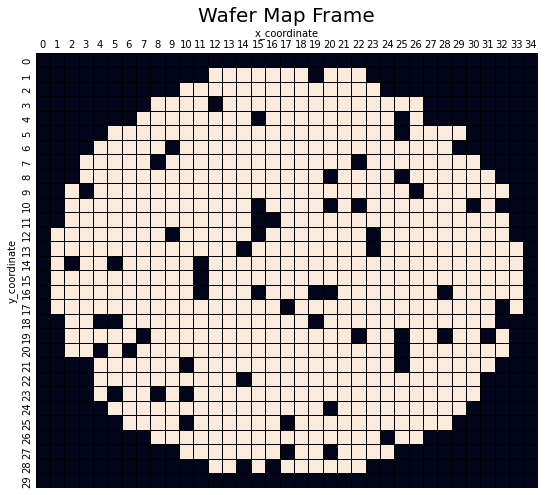

In [22]:
def visualization_wafer(map, size, title):
    plt.figure(figsize=(size+1,size))
    ax = sns.heatmap(map, linewidths=1, linecolor='black', cbar=False)
    plt.xlabel("x_coordinate")
    plt.ylabel("y_coordinate")
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    ax.tick_params(length=0)
    plt.title(title, fontsize=20)
    plt.show()
    
visualization_wafer(base_wafer, 8, "Wafer Map Frame")

In [23]:
# DefectList를 dataframe으로 변환.
defectList = []
for fp in file_path:
    readlines = readfile(fp)
    for line in readlines:
        if line[1] == 'DefectList':
            defectRow = int(line[0])
        elif line[1] == 'SummarySpec':
            defectRowEND = int(line[0]) - 1
        else:
            continue
        
    defectCols = ['FILE']
    defectCols.extend(readlines[defectRow-2][3:])
    
    if readlines[defectRow][1].isnumeric():
        for line in readlines[defectRow:defectRowEND]:
            if len(line) == 18:
                temp = [os.path.split(fp)[1]]
                temp.extend(line[1:])
                defectList.append(temp)
    else:
        temp = [os.path.split(fp)[1]]
        temp.extend(np.zeros(17).tolist())
        defectList.append(temp)

defect_df = pd.DataFrame(data=defectList, columns=defectCols)
defect_df[["XINDEX", "YINDEX"]] = defect_df[["XINDEX", "YINDEX"]].astype('int')
nodefect_df = defect_df[defect_df["DEFECTID"] == 0]
defect_df = defect_df[defect_df["DEFECTID"] != 0]
defect_df[["XINDEX","YINDEX"]] += [calib_x,calib_y]
defect_df = pd.concat([nodefect_df,defect_df]).sort_index()

In [24]:
# defect_df의 FILE columns 변경
defect_df.FILE = defect_df.FILE.apply(lambda x: x.split('.')[0])

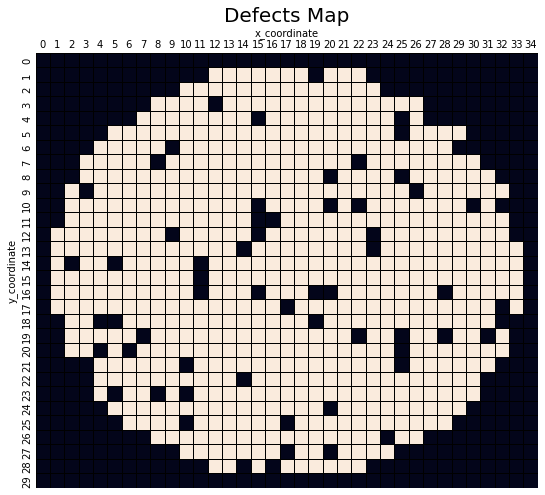

In [25]:
# defect 시각화
defectMaps=[]
for fp in file_path:
    base = base_wafer.copy()
    filename = os.path.split(fp)[1]
    defect_x = defect_df[defect_df.FILE == filename.split('.')[0]][["XINDEX"]].astype('int').values
    defect_y = defect_df[defect_df.FILE == filename.split('.')[0]][["YINDEX"]].astype('int').values
    
    if (defect_x == 0).all():
        pass
    else:
        for i in range(defect_x.size):
            base[defect_x[i][0], defect_y[i][0]] = 0.5
    defectMaps.append(base)
    
# 임의의 defect map 시각화
visualization_wafer(defectMaps[0],8, "Defects Map")

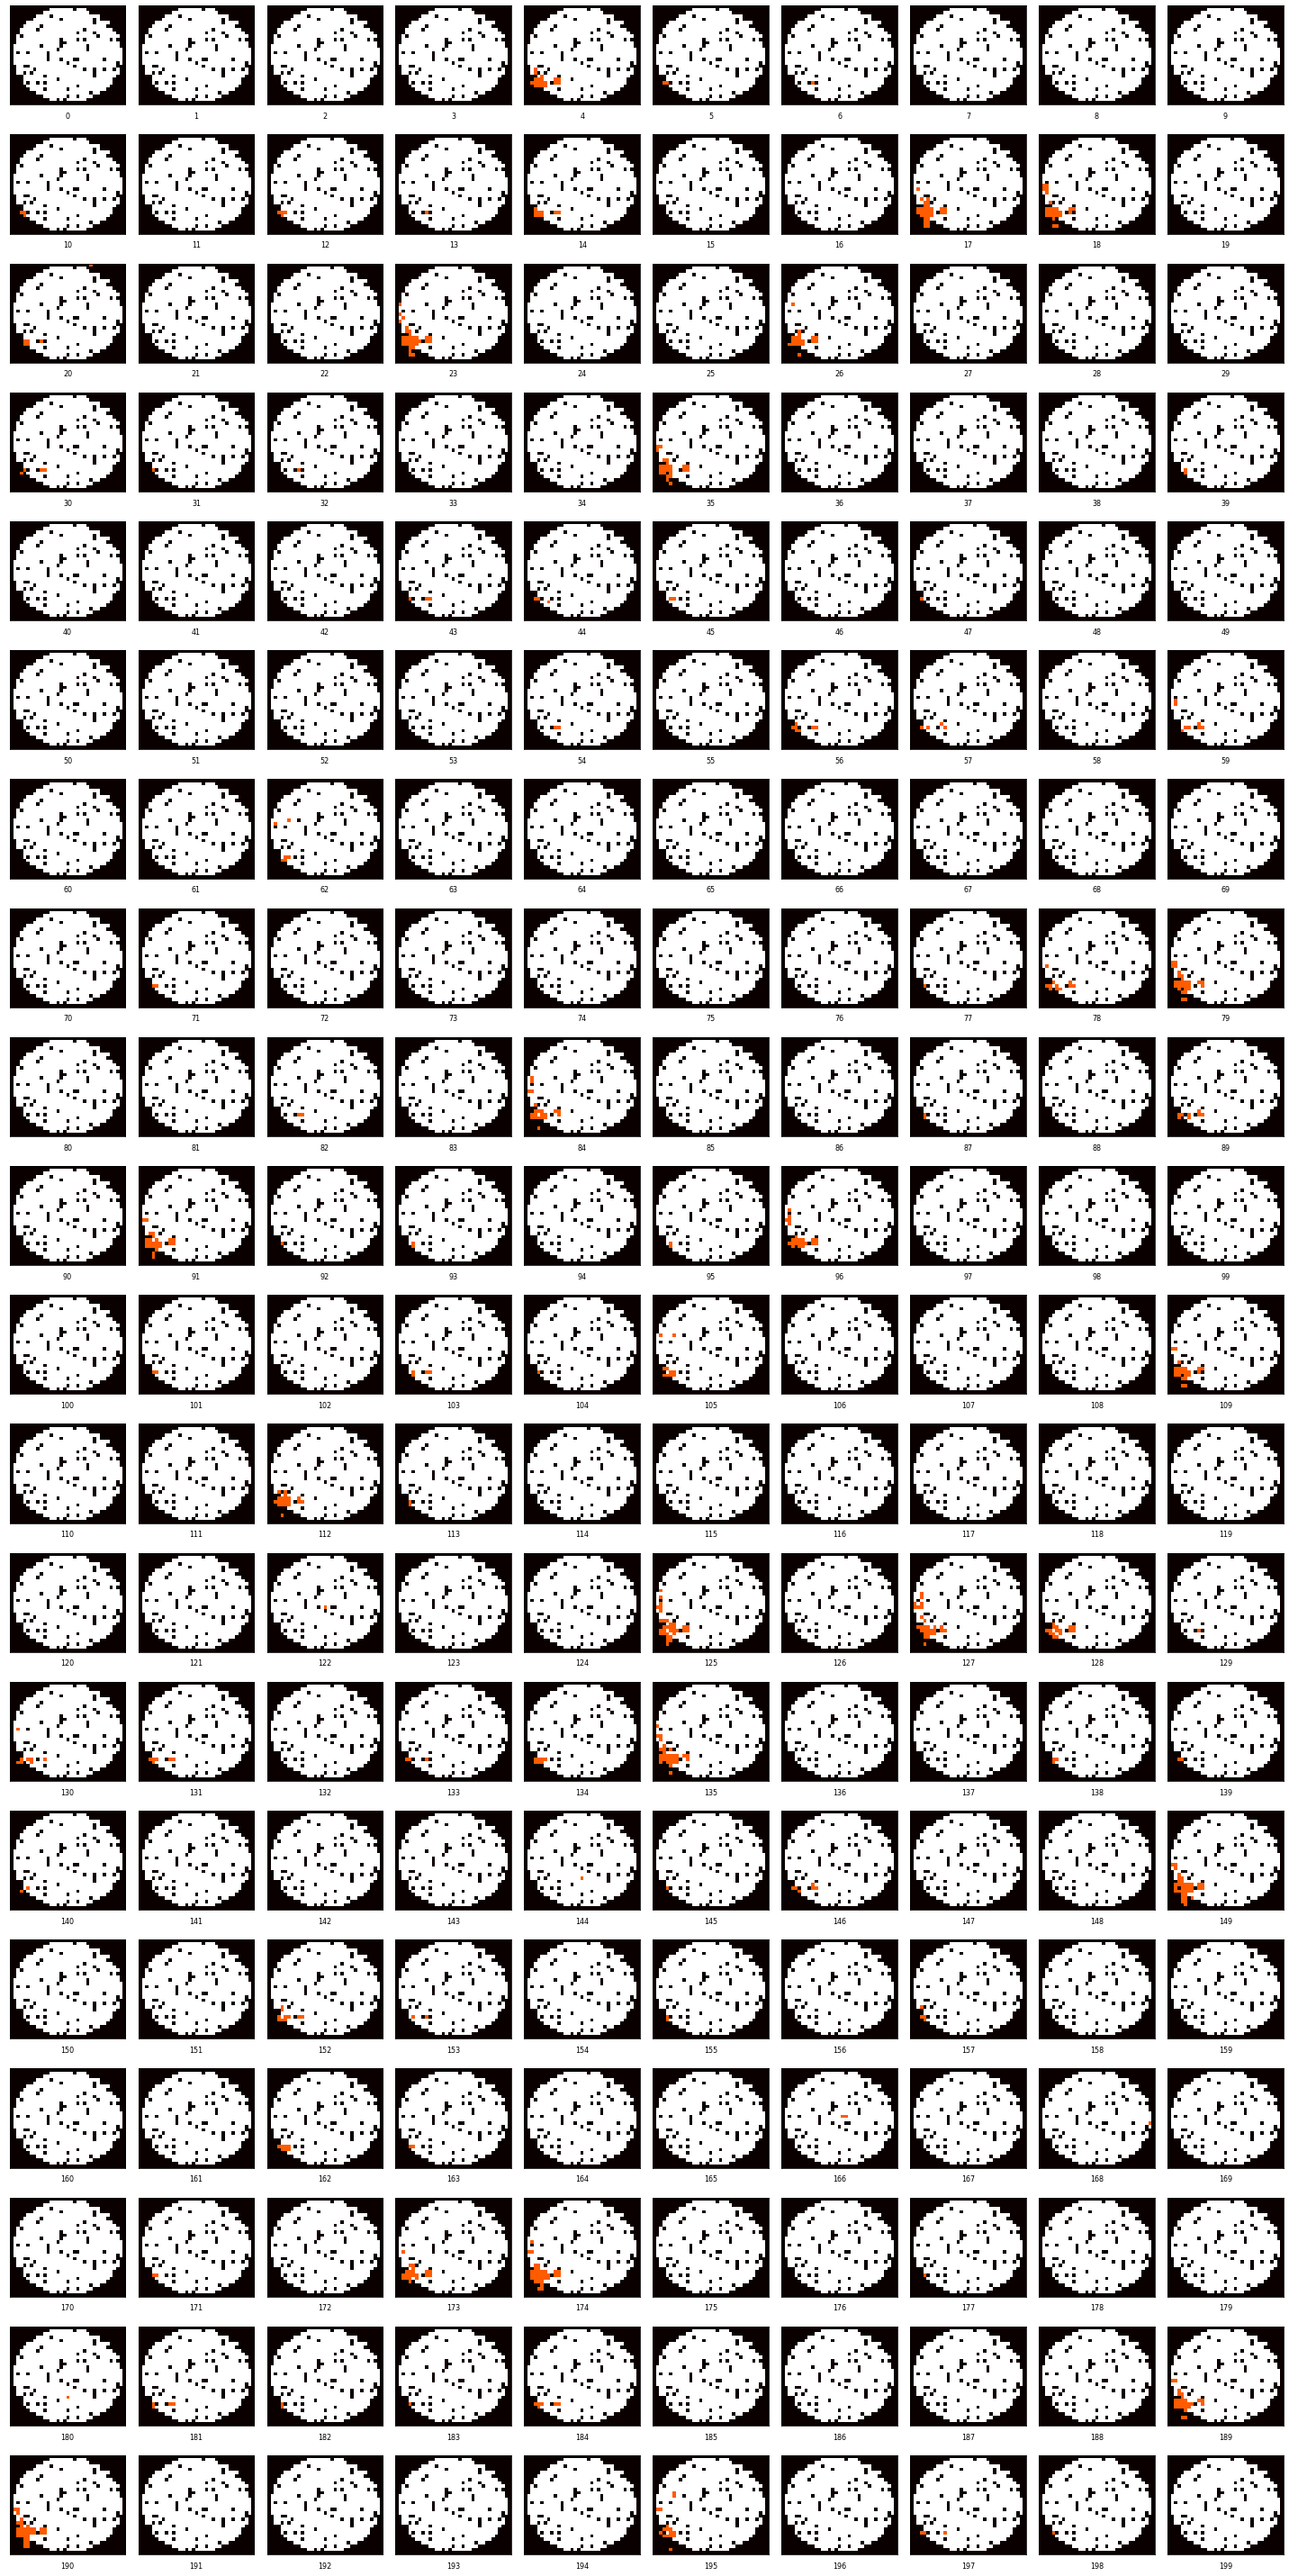

In [26]:
# 다중 wafer 시각화 (단순 추이를 보기 위함.)
fig, ax = plt.subplots(nrows=20, ncols=10, figsize=(20,40))
ax = ax.ravel(order='C')
for i in range(200):
    ax[i].imshow(defectMaps[i], cmap=cm.hot)
    ax[i].set_xlabel(f'{i}', fontsize=8)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.tight_layout()
plt.show()

## 분석용 데이터 생성

In [27]:
temp_df.head()

,filename,lotid,waferid,timestamp,machineid,stepid,deviceid
0,TAGS_REFLOW_INSP3_TAGHQ18T_00-08,TAGHQ18T,TAGHQ18-08,2022-12-07 14:34:20,M08AWD10,WAFER REFLOW INSP3,TAGHQ18T
1,TAGS_REFLOW_INSP3_TAGHS57T_00-22,TAGHS57T,TAGHS57-22,2022-12-07 14:42:50,M08AWD10,WAFER REFLOW INSP3,TAGHS57T
2,TAGM_REFLOW_INSP3_TAGHB30TA_00-01,TAGHB30TA,TAGHB30-01,2022-12-07 15:55:41,M08AWD10,WAFER REFLOW INSP3,TAGHB30TA
3,TAGM_REFLOW_INSP3_TAGHB30TA_00-10,TAGHB30TA,TAGHB30-10,2022-12-07 16:02:55,M08AWD10,WAFER REFLOW INSP3,TAGHB30TA
4,TAGM_REFLOW_INSP3_TAGHB30TA_00-12,TAGHB30TA,TAGHB30-12,2022-12-07 16:10:15,M08AWD10,WAFER REFLOW INSP3,TAGHB30TA


In [28]:
defect_df["map"] = defect_df[["XINDEX", "YINDEX"]].apply(list, axis=1)
defect_df.head(3)

,FILE,DEFECTID,XREL,YREL,XINDEX,YINDEX,XSIZE,YSIZE,DEFECTAREA,DSIZE,CLASSNUMBER,TEST,CLUSTERNUMBER,ROUGHBINNUMBER,FINEBINNUMBER,REVIEWSAMPLE,IMAGECOUNT,IMAGELIST,map
0,TDAS_REFLOW_INSP3_TDAJL02T_00-10,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0, 0]"
1,TAGS_REFLOW_INSP3_TAGHX17T_00-09,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0, 0]"
2,TDAS_REFLOW_INSP3_TDAJN10T_00-10,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0, 0]"


In [29]:
def appendFn(*listset):
    lst = []
    for list_ in listset:
        lst.append(list_)
    return lst

defect_temp = defect_df.groupby(['FILE'])["map"].apply(appendFn).reset_index()
defect_temp.map = defect_temp.map.apply(lambda x: np.array(x).squeeze(0))
defect_temp

,FILE,map
0,MI_MONITORING_KMIB086T_00-01,"[[0, 0]]"
1,TAGM_REFLOW_INSP3_TAGHB30TA_00-01,"[[0, 0]]"
2,TAGM_REFLOW_INSP3_TAGHB30TA_00-10,"[[0, 0]]"
3,TAGM_REFLOW_INSP3_TAGHB30TA_00-12,"[[0, 0]]"
4,TAGM_REFLOW_INSP3_TAGHB30TA_00-13,"[[0, 0]]"
...,...,...
205,TDAS_REFLOW_INSP3_TDAJN10T_00-20,"[[0, 0]]"
206,TDAS_REFLOW_INSP3_TDAJN10T_00-22,"[[0, 0]]"
207,TDAS_REFLOW_INSP3_TDAJN10T_00-23,"[[0, 0]]"
208,TDAS_REFLOW_INSP3_TDAJN10T_00-24,"[[0, 0]]"


In [30]:
df = pd.merge(temp_df, defect_temp, how='inner', left_on='filename', right_on='FILE').drop(columns=["FILE", "filename"])
df.head()

,lotid,waferid,timestamp,machineid,stepid,deviceid,map
0,TAGHQ18T,TAGHQ18-08,2022-12-07 14:34:20,M08AWD10,WAFER REFLOW INSP3,TAGHQ18T,"[[0, 0]]"
1,TAGHS57T,TAGHS57-22,2022-12-07 14:42:50,M08AWD10,WAFER REFLOW INSP3,TAGHS57T,"[[23, 10], [23, 10], [23, 10], [23, 10], [23, ..."
2,TAGHB30TA,TAGHB30-01,2022-12-07 15:55:41,M08AWD10,WAFER REFLOW INSP3,TAGHB30TA,"[[0, 0]]"
3,TAGHB30TA,TAGHB30-10,2022-12-07 16:02:55,M08AWD10,WAFER REFLOW INSP3,TAGHB30TA,"[[0, 0]]"
4,TAGHB30TA,TAGHB30-12,2022-12-07 16:10:15,M08AWD10,WAFER REFLOW INSP3,TAGHB30TA,"[[0, 0]]"


## 연속성 판정을 위한 Feature Engineering

1. Defects의 좌표를 거리와 각도로 표현.
2. 시계열순으로 Shift하여 데이터 batch 생성
3. 생성된 batch에 대해 Fast Fourier Transform

In [31]:
# hyperparameter
class cfg:
    seed = 1234
    n_window = 3 # 한 batch에 확인할 wafer 수 -> 10
    origin = [(base_wafer.shape[0]-1)/2, (base_wafer.shape[1]-1)/2] # wafer의 원점 정의

In [32]:
# batch dataset visualization v2
def dist(origin, defects):
    if defects[0] == [0,0]:
        return [-1]
    distance = [-1]
    for i in range(len(defects)):
        dist = 0
        for j in range(len(defects[i])):
            dist += (origin[j]-defects[i][j])**2
            if dist == 0:
                return distance
        dist **= 1/2
        distance.append(int(dist))
    return distance

def theta(origin, defects):
    if defects[0] == [0,0]:
        return [-180]
    theta = [-180]
    for i in range(len(defects)):
        rc_x = defects[i][0] - origin[0]
        rc_y = defects[i][1] - origin[1]
        ang = int(np.rad2deg(np.arctan2(rc_y, rc_x)))
        theta.append(ang) # 가시성을 위해 rad -> deg
    return theta

df["distance"] = df.map.apply(lambda x:dist(cfg.origin, x))
df["degree"] = df.map.apply(lambda x:theta(cfg.origin, x))

In [33]:
df

,lotid,waferid,timestamp,machineid,stepid,deviceid,map,distance,degree
0,TAGHQ18T,TAGHQ18-08,2022-12-07 14:34:20,M08AWD10,WAFER REFLOW INSP3,TAGHQ18T,"[[0, 0]]",[-1],[-180]
1,TAGHS57T,TAGHS57-22,2022-12-07 14:42:50,M08AWD10,WAFER REFLOW INSP3,TAGHS57T,"[[23, 10], [23, 10], [23, 10], [23, 10], [23, ...","[-1, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 1...","[-180, -39, -39, -39, -39, -39, -39, -39, -39,..."
2,TAGHB30TA,TAGHB30-01,2022-12-07 15:55:41,M08AWD10,WAFER REFLOW INSP3,TAGHB30TA,"[[0, 0]]",[-1],[-180]
3,TAGHB30TA,TAGHB30-10,2022-12-07 16:02:55,M08AWD10,WAFER REFLOW INSP3,TAGHB30TA,"[[0, 0]]",[-1],[-180]
4,TAGHB30TA,TAGHB30-12,2022-12-07 16:10:15,M08AWD10,WAFER REFLOW INSP3,TAGHB30TA,"[[0, 0]]",[-1],[-180]
...,...,...,...,...,...,...,...,...,...
205,TDAJL86T,TDAJL86-20,2023-02-06 17:52:35,M08AWD10,WAFER REFLOW INSP3,TDAJL86T,"[[0, 0]]",[-1],[-180]
206,TDAJL86T,TDAJL86-21,2023-02-06 17:59:46,M08AWD10,WAFER REFLOW INSP3,TDAJL86T,"[[0, 0]]",[-1],[-180]
207,TDAJL86T,TDAJL86-22,2023-02-06 18:07:13,M08AWD10,WAFER REFLOW INSP3,TDAJL86T,"[[0, 0]]",[-1],[-180]
208,TDAJL86T,TDAJL86-24,2023-02-06 18:14:35,M08AWD10,WAFER REFLOW INSP3,TDAJL86T,"[[0, 0]]",[-1],[-180]


In [34]:
def batch_graph(degree, distance, graph=True):
    intp = interpolate.interp1d(degree, distance, kind='linear') # linear, cubic, nearest ...
    xnew = np.arange(min(degree), max(degree), 0.1)
    
    if graph:
        fig = plt.figure(figsize=(5,2))
        plt.plot(degree, distance, "ro", xnew, intp(xnew))
        plt.xlim([-180, -180+360*cfg.n_window])
        plt.ylim([0, 20])
        xtick = np.array(degree) % 360
        plt.xticks(degree, xtick, rotation=45)
        plt.show()
    return intp, xnew

# FFT graph
def fft_graph(input, graph=True):
    Y = np.fft.fft(input)
    amp = abs(Y) * (2/len(Y))
    freq = np.fft.fftfreq(len(Y), 1/1000)

    amp = amp[0:20]
    freq = freq[0:20]
    
    if graph:
        plt.figure(figsize=(5,2))
        plt.stem(freq, amp)
        plt.grid(True)
        plt.show()
    return amp

In [35]:
# 전체 데이터에 대해 진행.
def amp_data(input):
    Y = np.fft.fft(input)
    amp = abs(Y) * (2/len(Y))
    return amp[0:20]

In [36]:
# fft그래프 visualization
def visualization_graph(df, case, graph=True):
    df["case"] = case
    nRows = len(df) - cfg.n_window + 1
    for i in range(nRows):
        df_dist = df.distance[i:cfg.n_window + i].tolist()
        batch_dist = []
        for dist in df_dist:
            try:
                for d in dist:
                    batch_dist.append(d)
            except:
                pass
        df_deg = df.degree[i:cfg.n_window + i].tolist()
        batch_deg = []
        for n, deg in enumerate(df_deg):
            try:
                for d in deg:
                    batch_deg.append(d + 360*n)
            except:
                pass
        batch_dist.append(-1)    
        batch_deg.append(-180 + 360*(n+1))    
            
        print(f"Index_{df.at[i+cfg.n_window-1, 'index']}")
        intp, xnew = batch_graph(batch_deg, batch_dist, graph)
        fft_graph(intp(xnew), graph)
    return 

Case1: ('M08AWD10', 'WAFER REFLOW INSP3', 'TAGHQ18T')
Case2: ('M08AWD10', 'WAFER REFLOW INSP3', 'TAGHS57T')
Case3: ('M08AWD10', 'WAFER REFLOW INSP3', 'TAGHB30TA')
Index_4


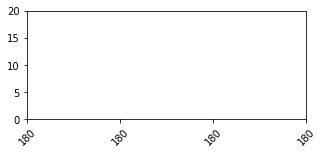

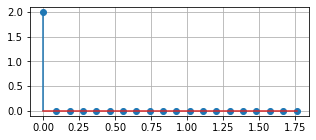

Index_5


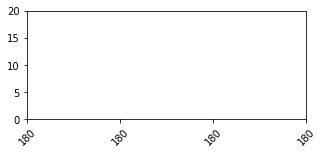

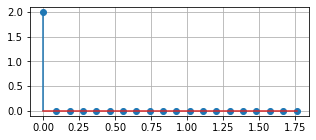

Index_6


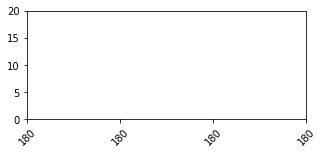

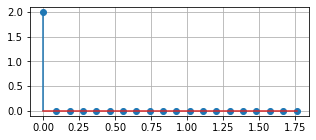

Index_7


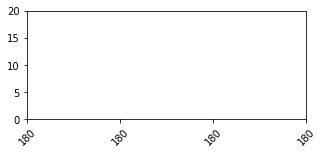

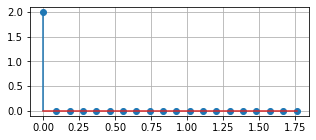

Index_8


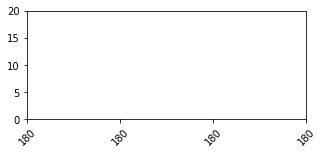

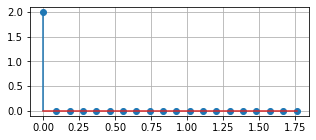

Case4: ('M08AWD10', 'WAFER REFLOW INSP3', 'TAGHN57TA')
Case5: ('M08AWD10', 'WAFER REFLOW INSP3', 'TAGHD39TF')
Case6: ('M08AWD10', 'WAFER REFLOW INSP3', 'TAGHU26TA')
Case7: ('M08AWD10', 'WAFER REFLOW INSP3', 'TAGHW48TA')
Index_16


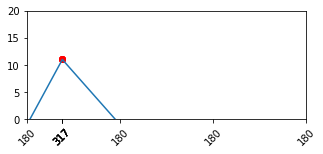

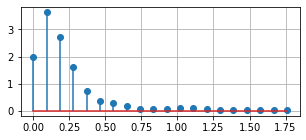

Index_17


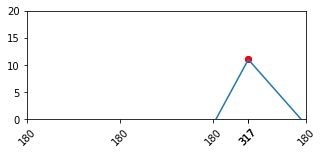

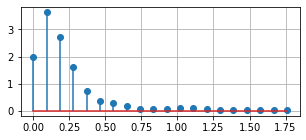

Index_18


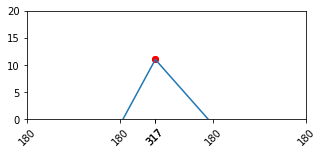

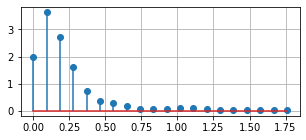

Index_19


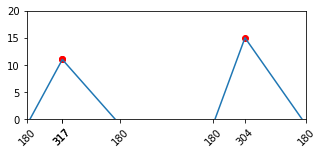

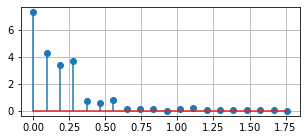

Index_20


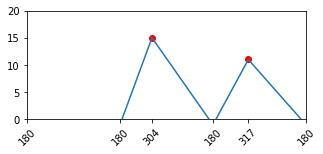

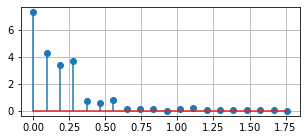

Index_21


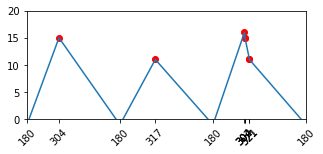

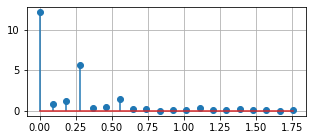

Index_22


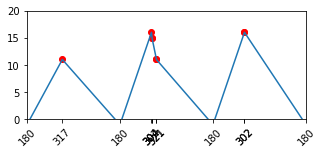

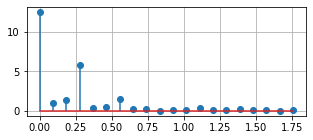

Index_23


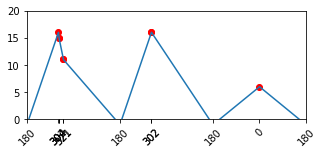

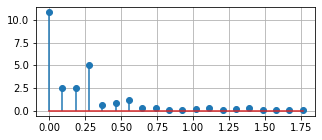

Index_24


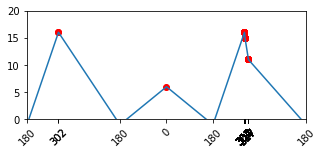

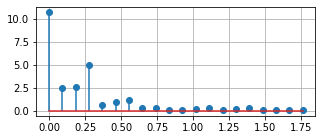

Index_25


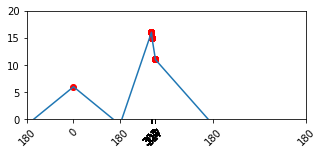

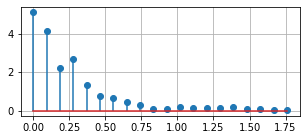

Index_26


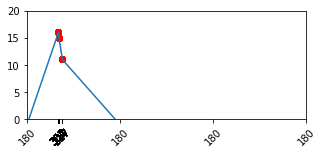

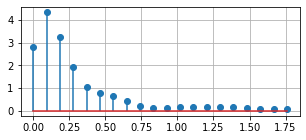

Index_27


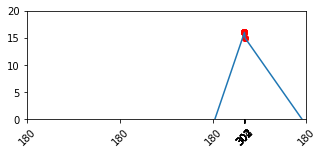

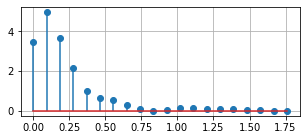

Index_28


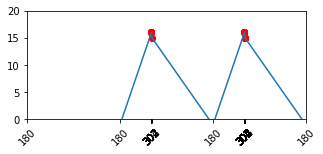

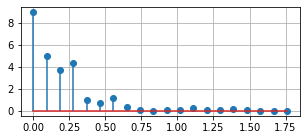

Index_29


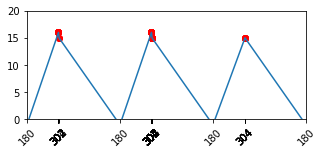

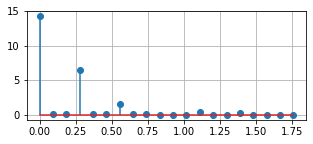

Index_30


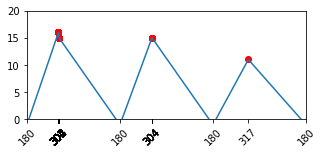

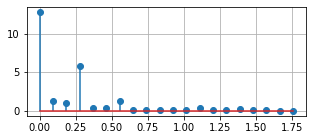

Case8: ('M08AWD10', 'WAFER REFLOW INSP3', 'TAGHX32TA')
Index_33


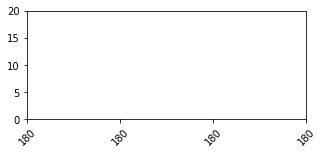

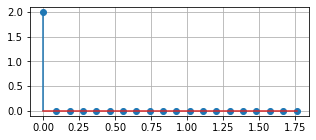

Index_34


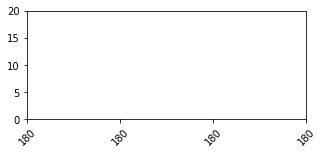

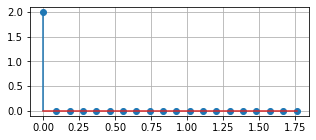

Index_35


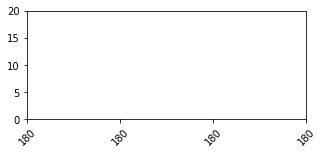

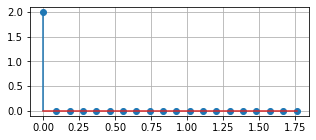

Index_36


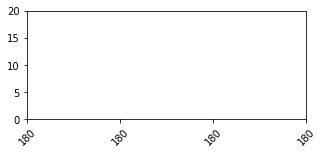

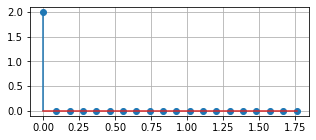

Index_37


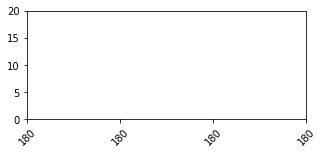

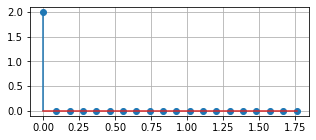

Index_38


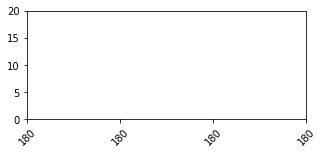

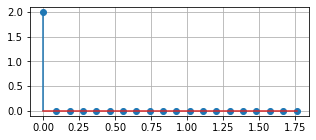

Index_39


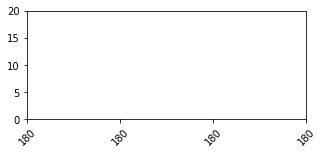

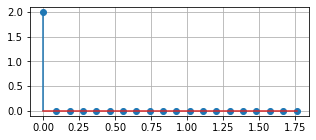

Index_40


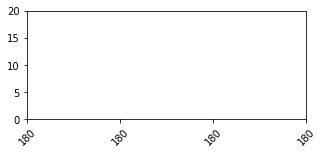

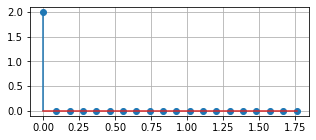

Index_41


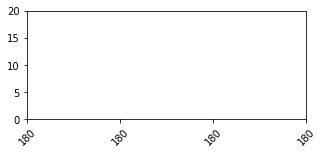

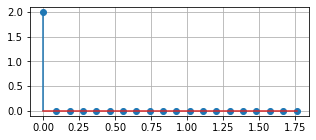

Index_42


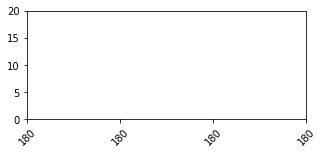

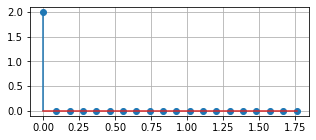

Index_43


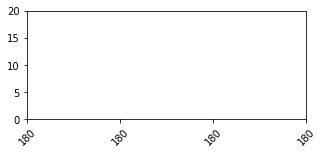

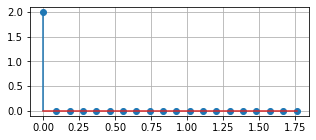

Index_44


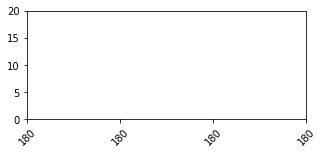

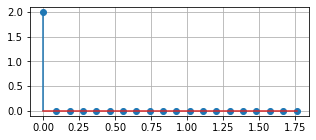

Index_45


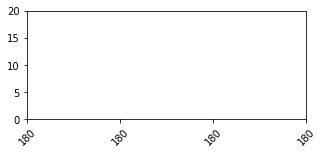

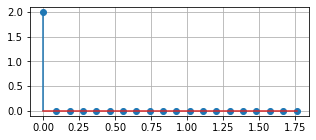

Case9: ('M08AWD10', 'WAFER REFLOW INSP3', 'TAGHX17T')
Index_48


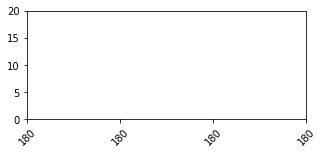

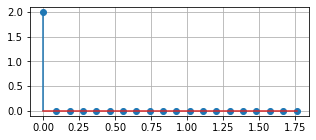

Index_49


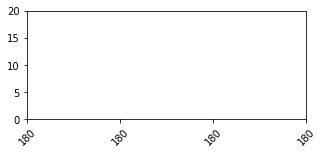

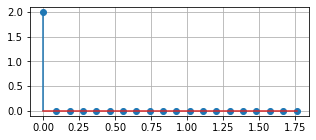

Index_50


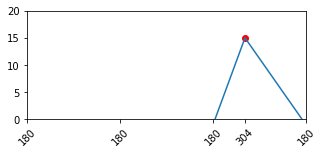

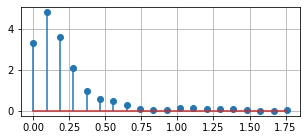

Index_51


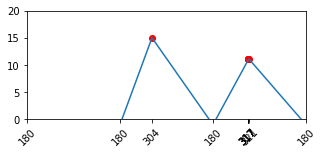

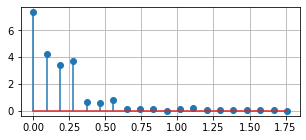

Index_52


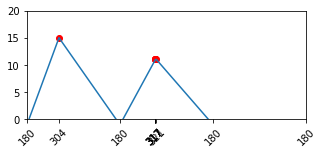

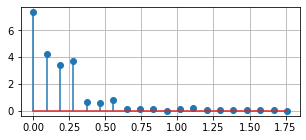

Index_53


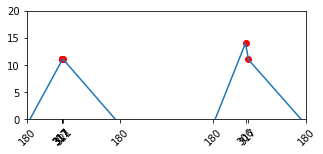

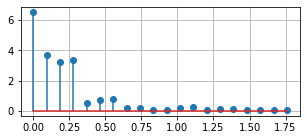

Index_54


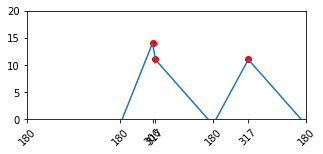

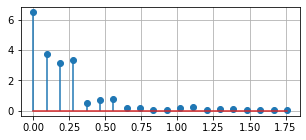

Index_55


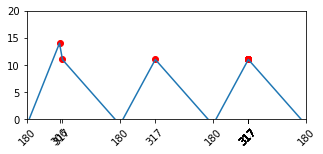

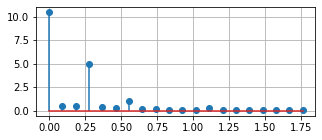

Index_56


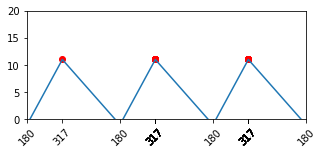

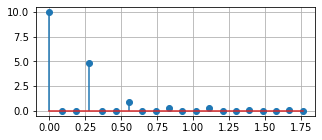

Index_57


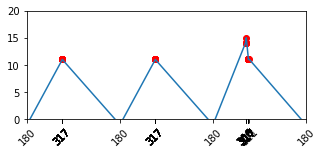

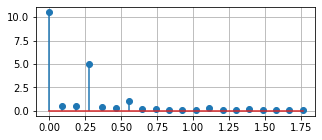

Case10: ('M08AWD10', 'WAFER REFLOW INSP3', 'TAGHS57TA')
Index_60


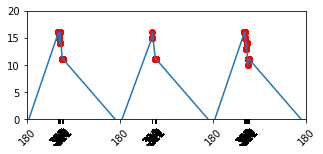

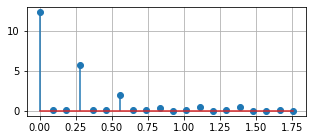

Index_61


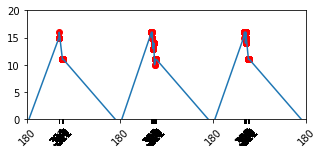

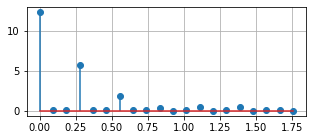

Index_62


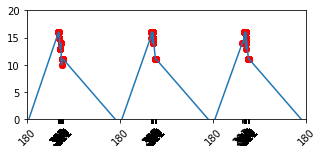

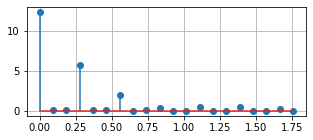

Index_63


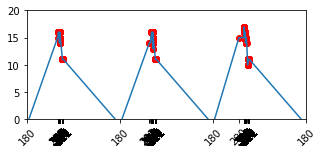

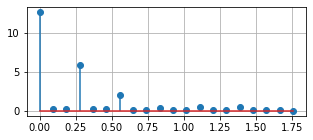

Index_64


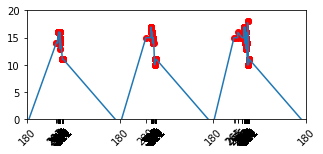

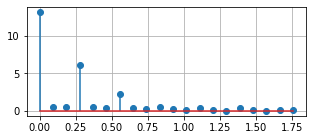

Index_65


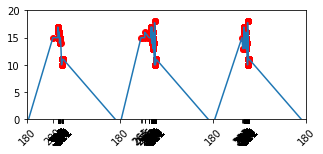

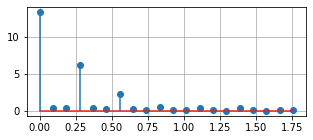

Index_66


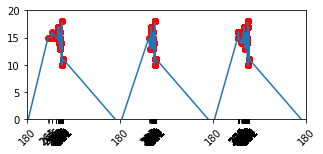

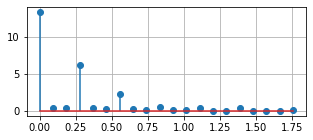

Index_67


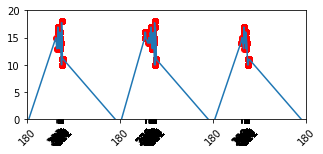

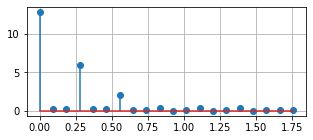

Index_68


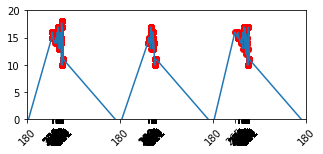

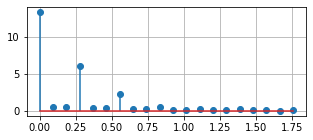

Index_69


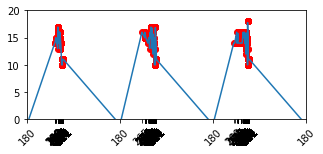

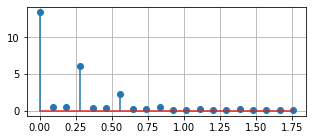

Index_70


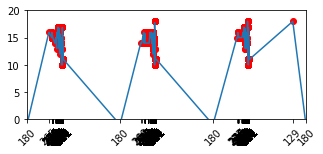

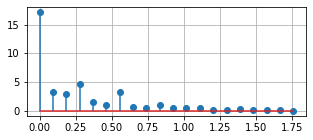

Index_71


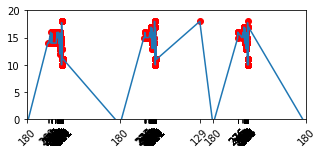

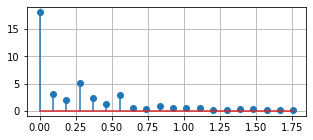

Index_72


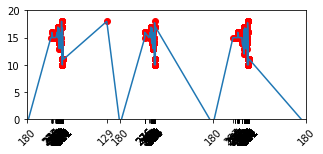

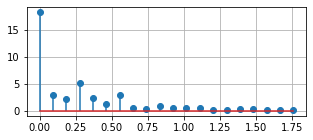

Index_73


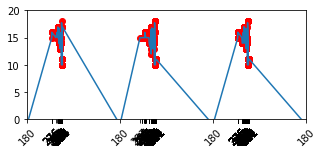

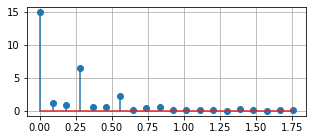

Index_74


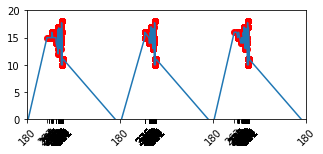

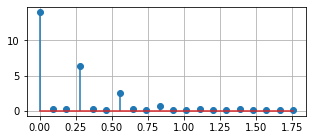

Index_75


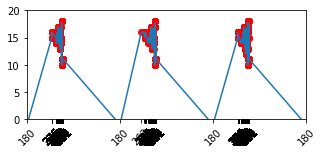

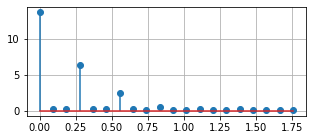

Index_76


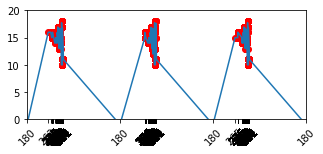

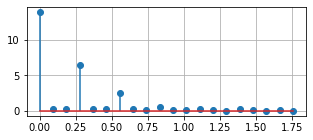

Index_77


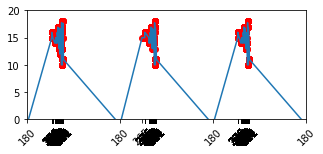

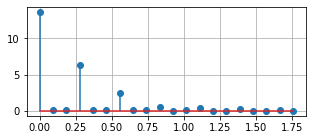

Index_78


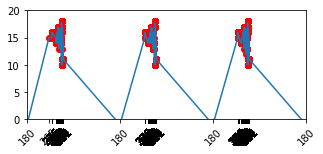

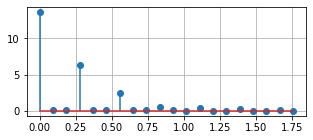

Index_79


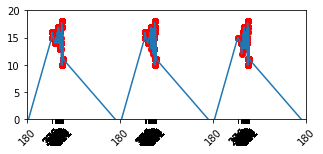

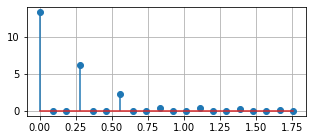

Index_80


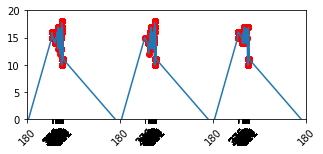

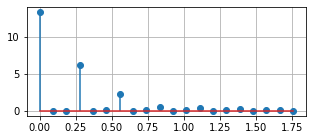

Index_81


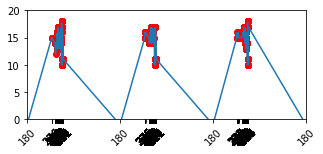

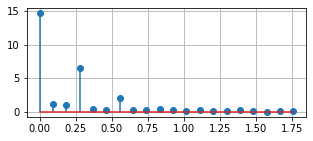

Case11: ('M08AWD10', 'WAFER REFLOW INSP3', 'TAGH734TA')
Index_84


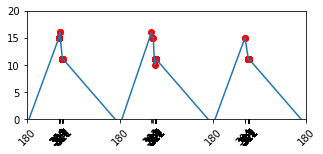

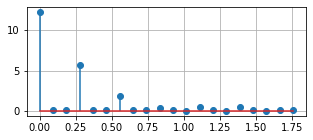

Index_85


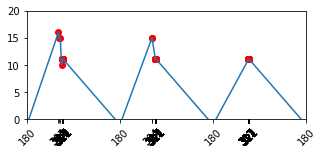

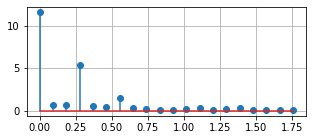

Case12: ('M08AWD10', 'WAFER REFLOW INSP3', 'TAGH973TA')
Index_88


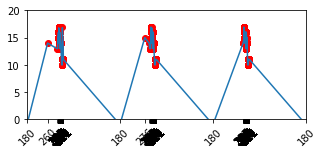

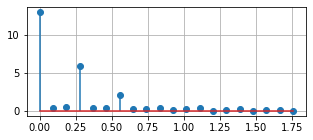

Index_89


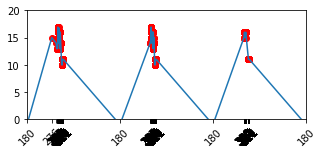

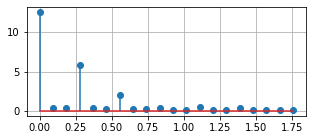

Index_90


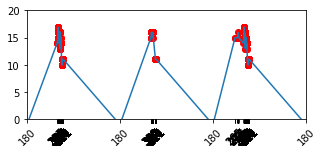

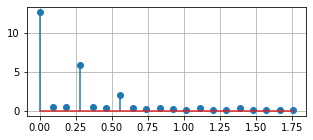

Case13: ('M08AWD10', 'WAFER REFLOW INSP3', 'TAGHC32TF')
Index_93


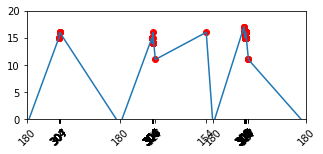

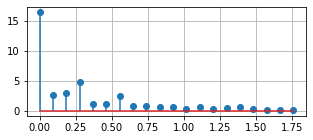

Case14: ('M08AWD10', 'WAFER REFLOW INSP3', 'TAGHA10TA')
Case15: ('M08AWD10', 'WAFER REFLOW INSP3', 'TAGHC65TA')
Case16: ('M08AWD10', 'WAFER REFLOW INSP3', 'TAGH992TB')
Index_99


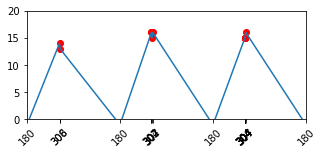

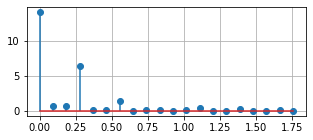

Index_100


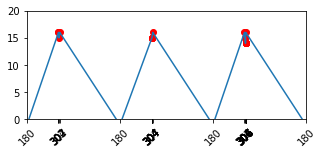

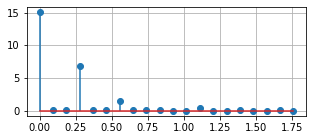

Index_101


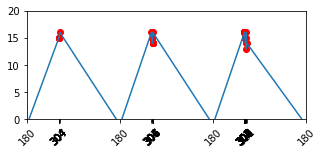

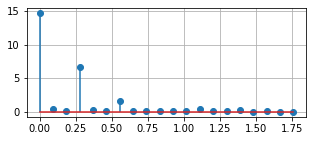

Case17: ('M08AWD10', 'WAFER REFLOW INSP3', 'TAGHA04TA')
Index_104


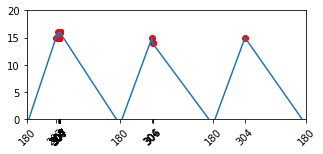

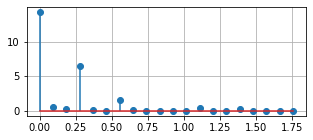

Index_105


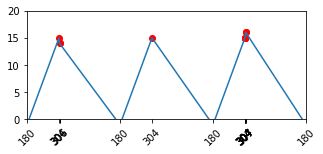

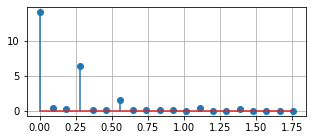

Case18: ('M08AWD10', 'WAFER REFLOW INSP3', 'TAGHY65T')
Index_108


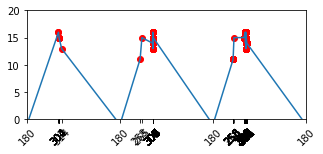

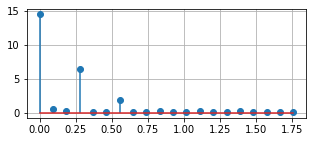

Index_109


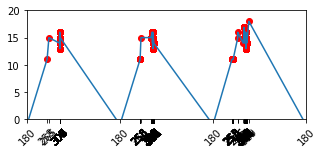

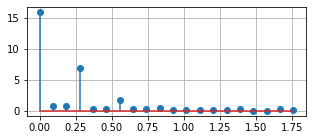

Case19: ('M08AWD10', 'WAFER REFLOW INSP3', 'TAGHX65T')
Index_112


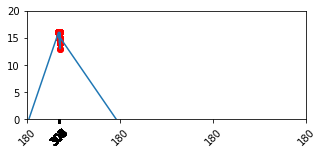

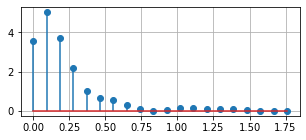

Case20: ('M08AWD10', 'WAFER REFLOW INSP3', 'TAGHS75T')
Index_115


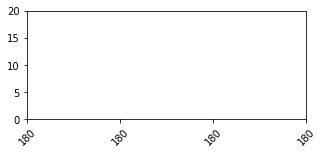

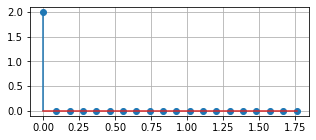

Index_116


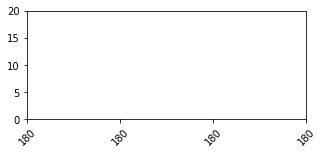

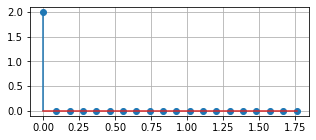

Index_117


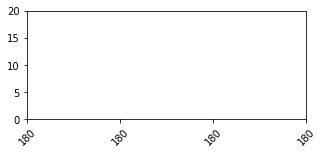

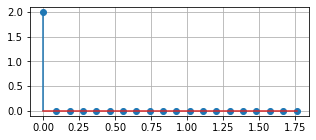

Index_118


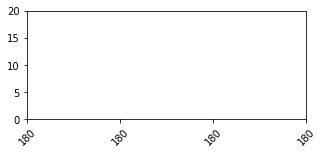

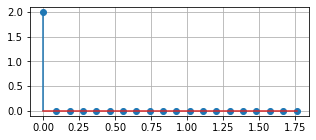

Index_119


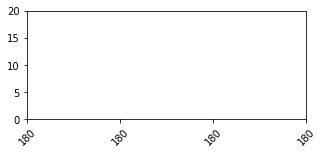

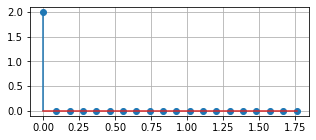

Index_120


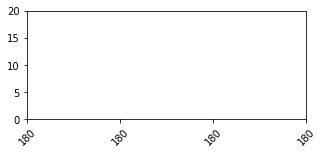

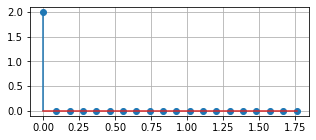

Index_121


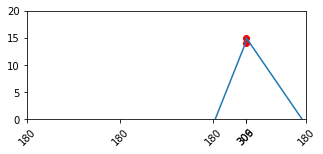

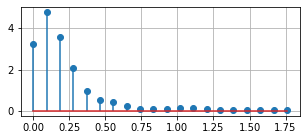

Index_122


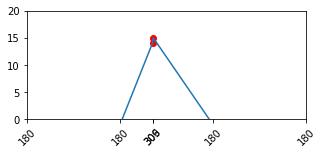

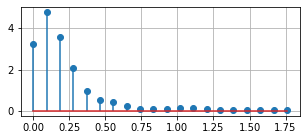

Index_123


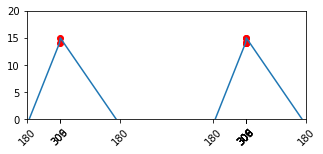

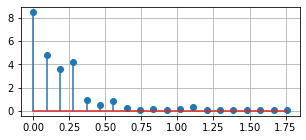

Index_124


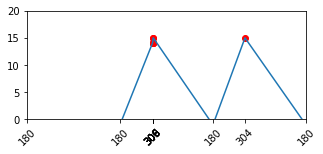

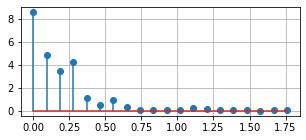

Index_125


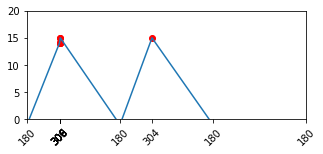

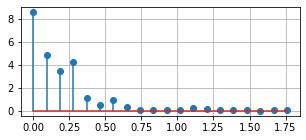

Index_126


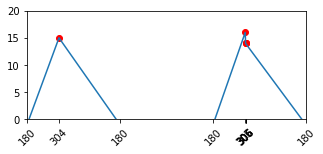

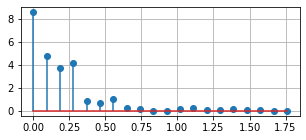

Index_127


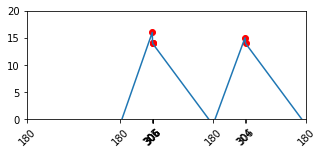

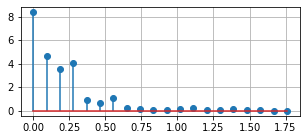

Index_128


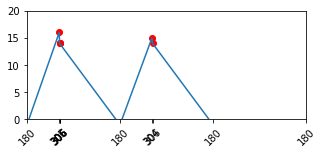

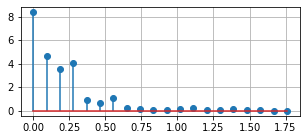

Index_129


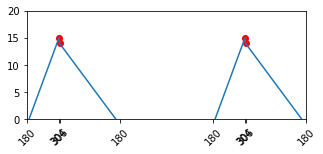

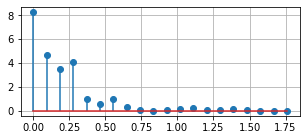

Index_130


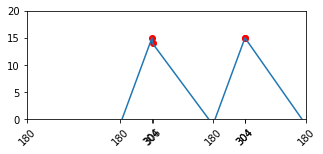

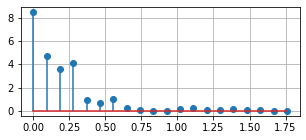

Index_131


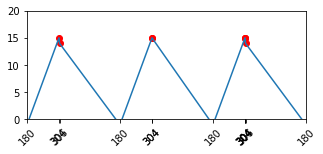

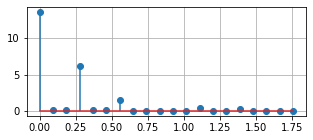

Index_132


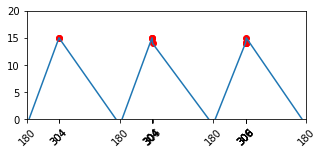

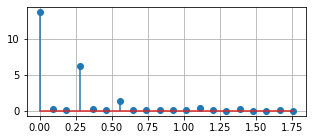

Index_133


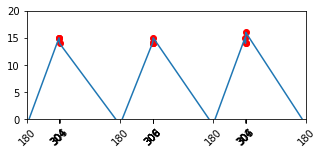

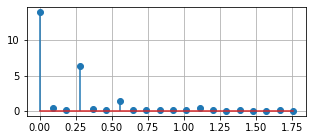

Index_134


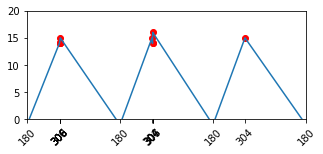

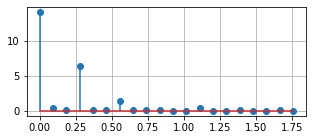

Index_135


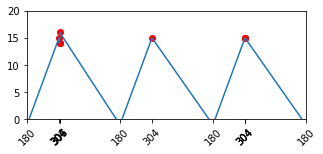

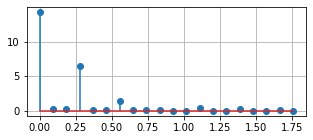

Index_136


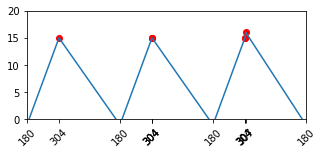

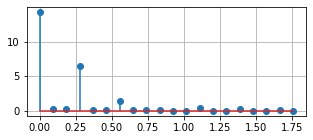

Index_137


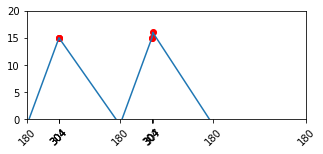

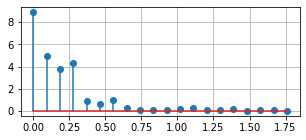

Case21: ('M08AWD10', 'WAFER REFLOW INSP3', 'KMIB086T')
데이터 없음
Case22: ('M08AWD10', 'WAFER REFLOW INSP3', 'TDAJL20TA')
Case23: ('M08AWD10', 'WAFER REFLOW INSP3', 'TDAJN10T')
Index_142


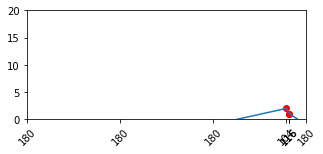

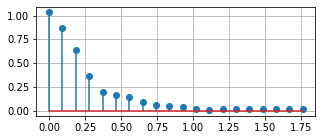

Index_143


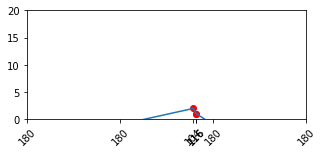

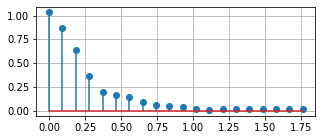

Index_144


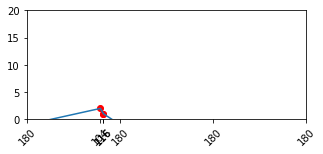

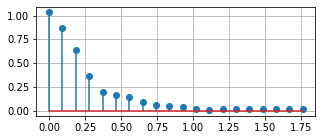

Index_145


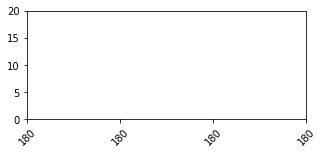

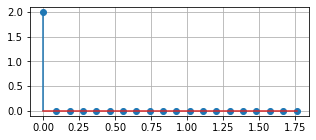

Index_146


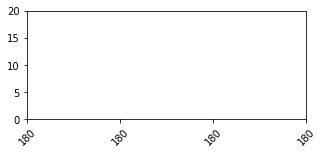

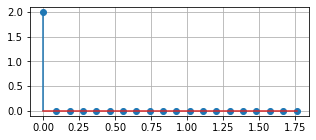

Index_147


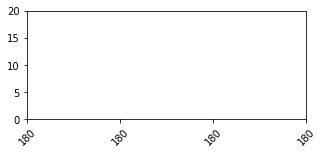

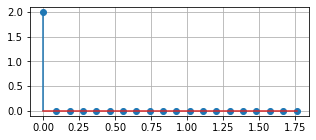

Index_148


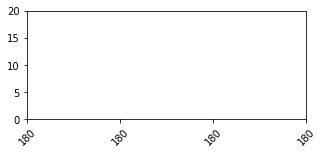

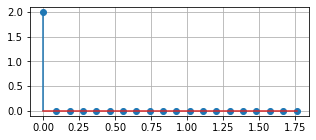

Index_149


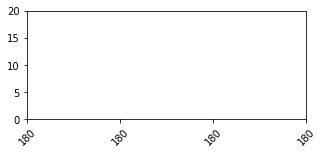

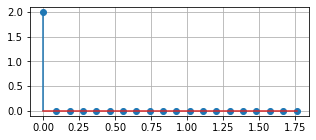

Index_150


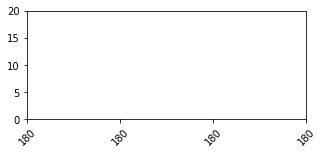

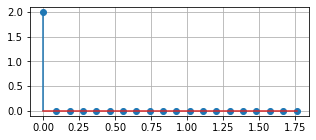

Index_151


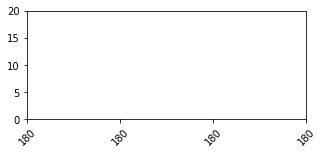

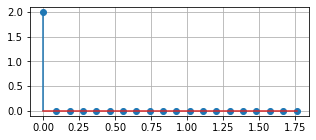

Index_152


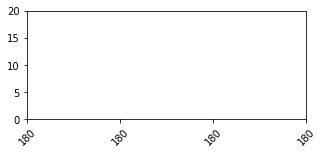

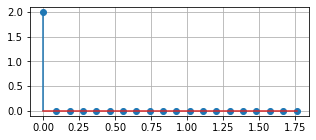

Index_153


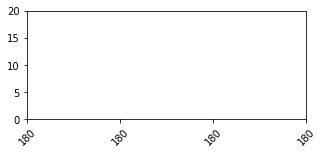

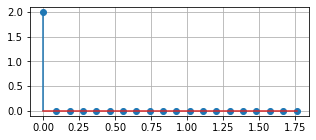

Index_154


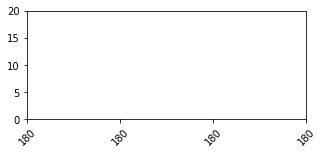

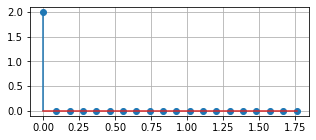

Index_155


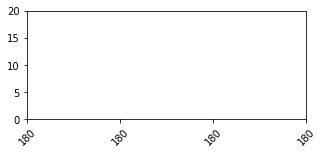

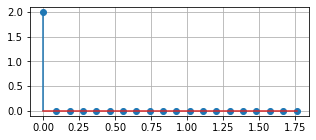

Index_156


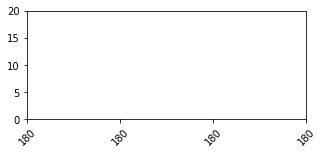

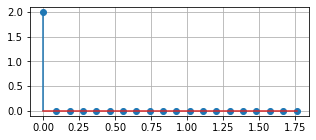

Index_157


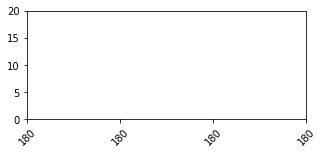

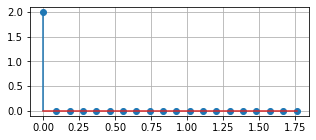

Index_158


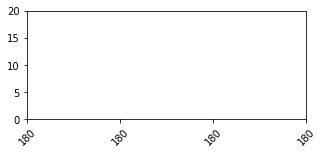

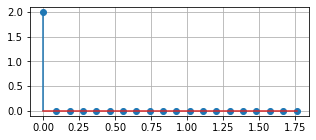

Index_159


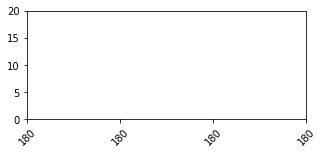

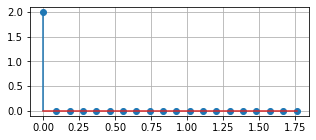

Case24: ('M08AWD10', 'WAFER REFLOW INSP3', 'TDAJM12TA')
Index_162


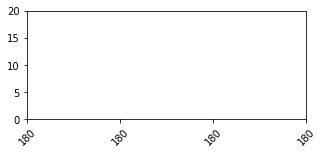

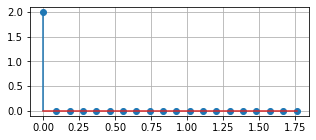

Index_163


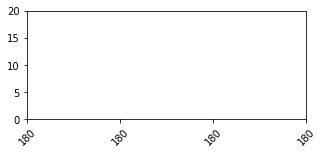

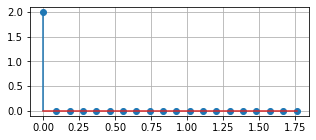

Index_164


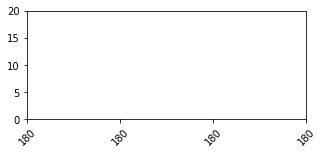

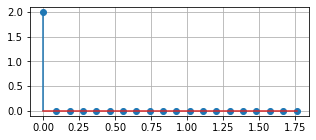

Index_165


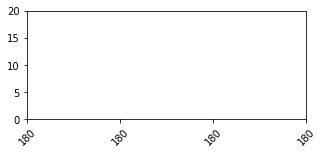

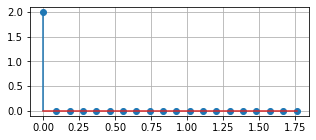

Index_166


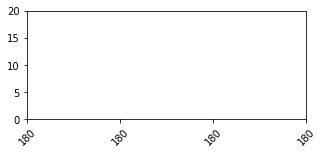

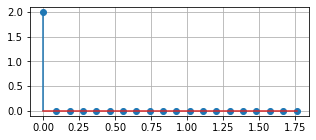

Index_167


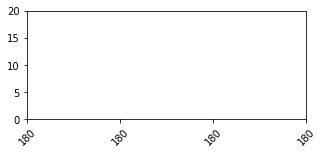

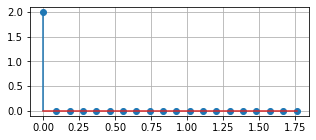

Case25: ('M08AWD10', 'WAFER REFLOW INSP3', 'TDAJM32TA')
Case26: ('M08AWD10', 'WAFER REFLOW INSP3', 'TDAJL02T')
Index_171


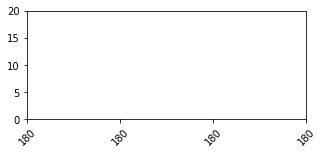

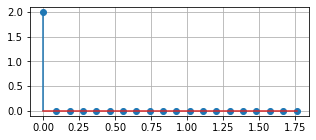

Index_172


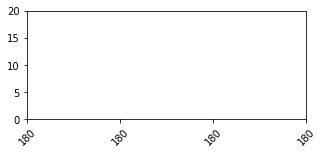

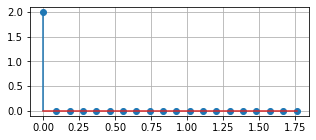

Index_173


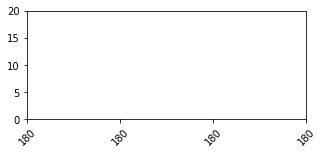

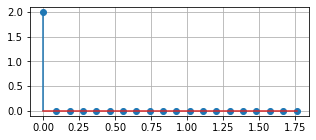

Index_174


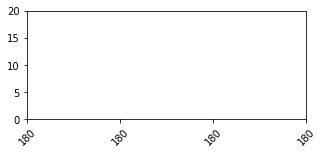

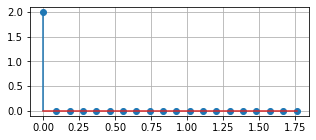

Index_175


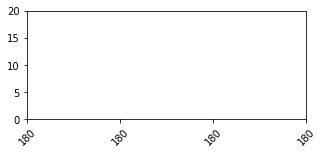

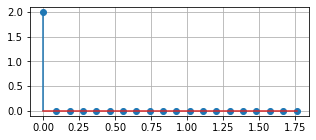

Index_176


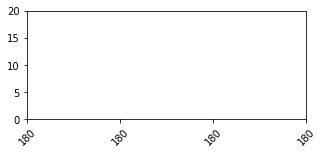

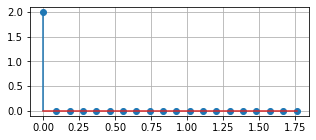

Index_177


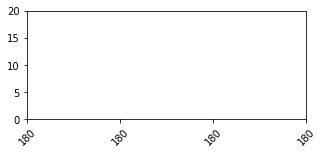

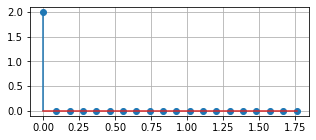

Index_178


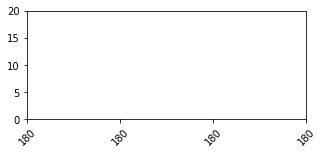

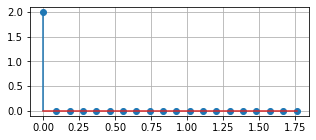

Index_179


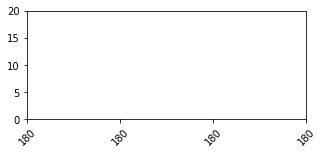

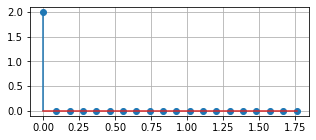

Index_180


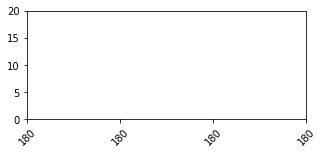

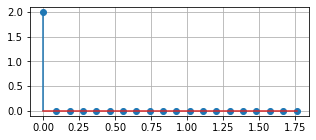

Index_181


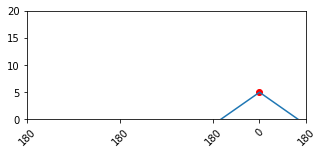

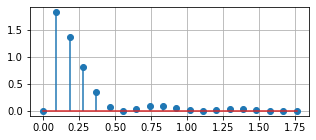

Index_182


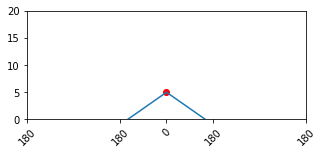

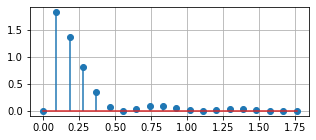

Index_183


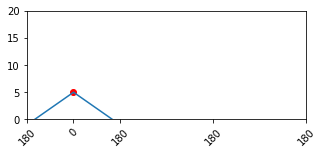

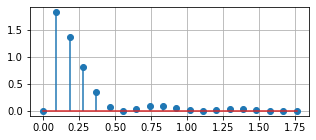

Index_184


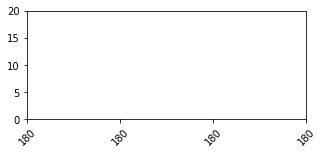

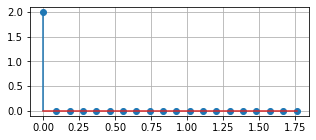

Index_185


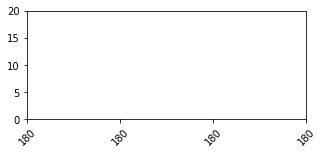

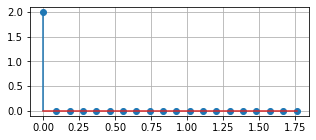

Index_186


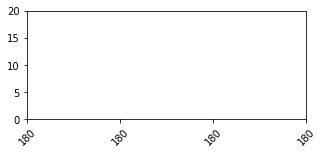

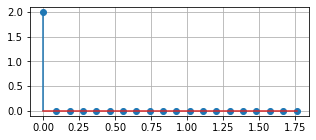

Case27: ('M08AWD10', 'WAFER REFLOW INSP3', 'TDAJL86T')
Index_189


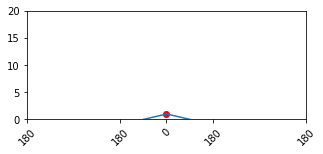

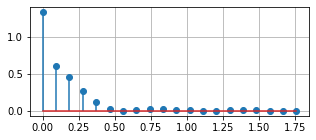

Index_190


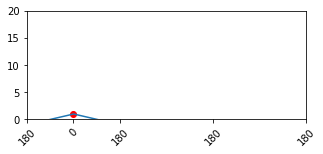

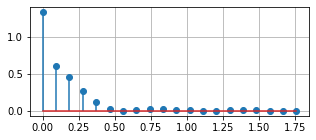

Index_191


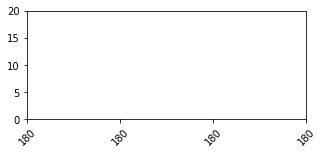

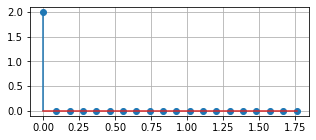

Index_192


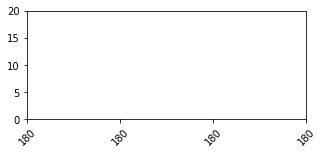

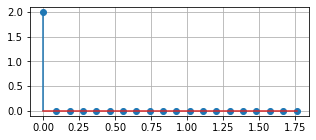

Index_193


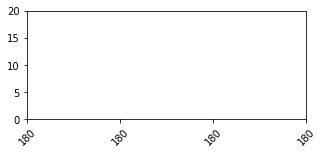

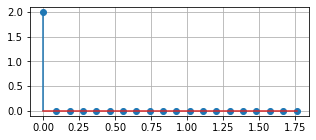

Index_194


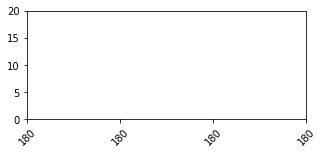

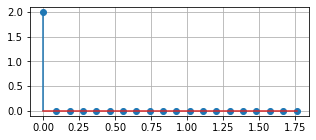

Index_195


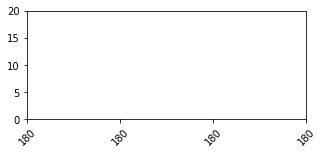

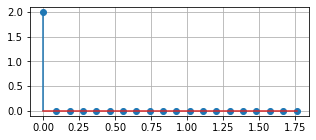

Index_196


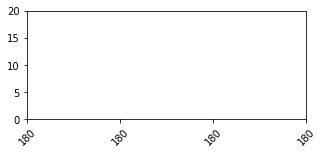

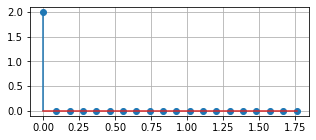

Index_197


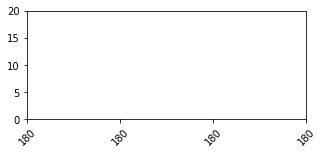

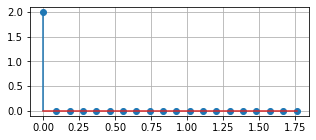

Index_198


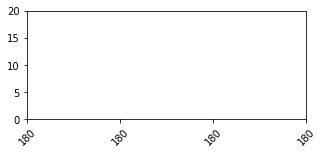

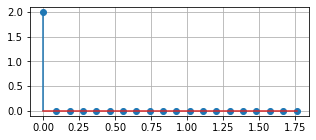

Index_199


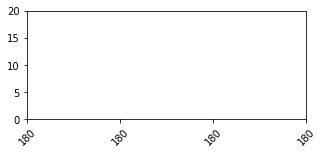

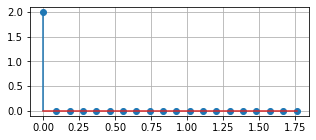

Index_200


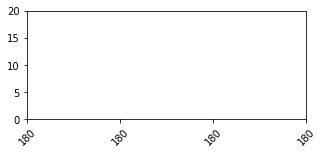

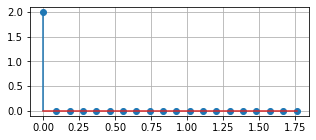

Index_201


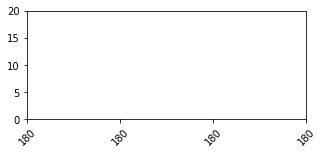

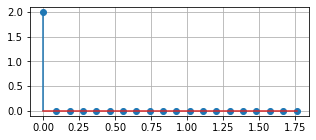

Index_202


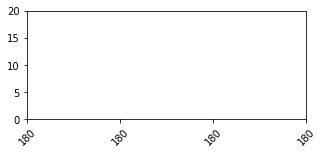

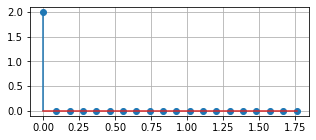

Index_203


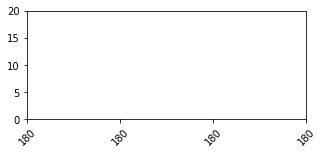

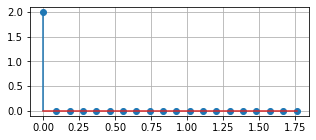

Index_204


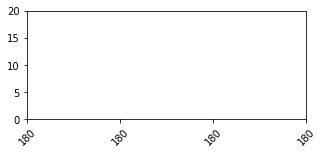

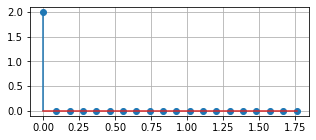

Index_205


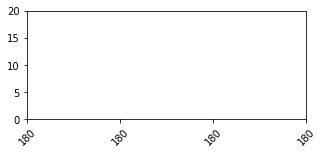

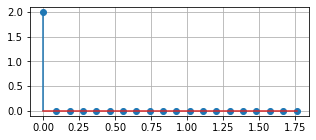

Index_206


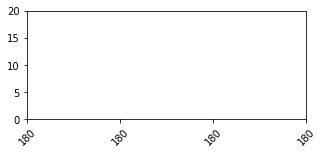

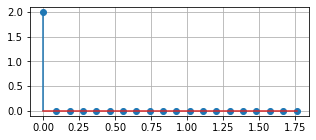

Index_207


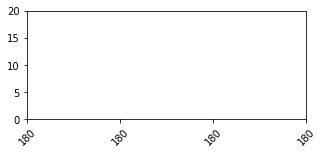

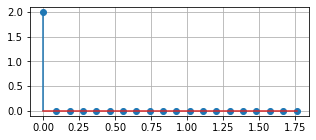

Index_208


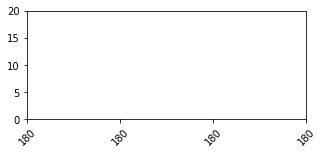

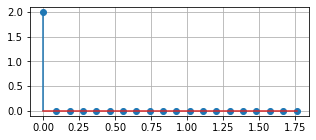

Index_209


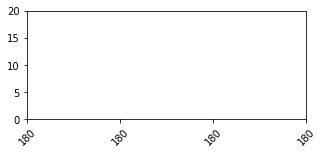

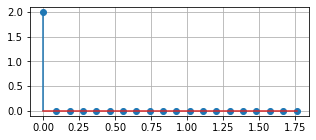

Case28: ('M08AWD10', 'MI_MONITORING', 'TAGHQ18T')
데이터 없음
Case29: ('M08AWD10', 'MI_MONITORING', 'TAGHS57T')
데이터 없음
Case30: ('M08AWD10', 'MI_MONITORING', 'TAGHB30TA')
데이터 없음
Case31: ('M08AWD10', 'MI_MONITORING', 'TAGHN57TA')
데이터 없음
Case32: ('M08AWD10', 'MI_MONITORING', 'TAGHD39TF')
데이터 없음
Case33: ('M08AWD10', 'MI_MONITORING', 'TAGHU26TA')
데이터 없음
Case34: ('M08AWD10', 'MI_MONITORING', 'TAGHW48TA')
데이터 없음
Case35: ('M08AWD10', 'MI_MONITORING', 'TAGHX32TA')
데이터 없음
Case36: ('M08AWD10', 'MI_MONITORING', 'TAGHX17T')
데이터 없음
Case37: ('M08AWD10', 'MI_MONITORING', 'TAGHS57TA')
데이터 없음
Case38: ('M08AWD10', 'MI_MONITORING', 'TAGH734TA')
데이터 없음
Case39: ('M08AWD10', 'MI_MONITORING', 'TAGH973TA')
데이터 없음
Case40: ('M08AWD10', 'MI_MONITORING', 'TAGHC32TF')
데이터 없음
Case41: ('M08AWD10', 'MI_MONITORING', 'TAGHA10TA')
데이터 없음
Case42: ('M08AWD10', 'MI_MONITORING', 'TAGHC65TA')
데이터 없음
Case43: ('M08AWD10', 'MI_MONITORING', 'TAGH992TB')
데이터 없음
Case44: ('M08AWD10', 'MI_MONITORING', 'TAGHA04TA')
데이터 없음
Case45: ('M08AWD1

In [168]:
# 정상 / 이상 데이터에 대한 예시 그래프
machine_type = df["machineid"].unique()
step_type = df["stepid"].unique()
device_type = df["deviceid"].unique()

temp_df = df.copy()

case = 0
case_dict = dict()
for m in machine_type:
    for s in step_type:
        for d in device_type:
            case += 1
            print("==="*30)
            print(f"Case{case}: {m,s,d}")
            case_dict["Case"+str(case)] = [m,s,d]
                
            temp = df[(df.machineid == m) & (df.stepid == s) & (df.deviceid == d)].reset_index()
            if len(temp) == 0:
                print("데이터 없음")
                continue
            
            visualization_graph(temp, case, True)
            print("==="*30)

In [37]:
# fft후, amplitude 값 컬럼 추가
def add_amplitude(df):
    nRows = len(df) - cfg.n_window + 1
    for i in tqdm(range(nRows)):
        df_dist = df.distance[i:cfg.n_window + i].tolist()
        batch_dist = []
        for dist in df_dist:
            try:
                for d in dist:
                    batch_dist.append(d)
            except:
                pass
            
        df_deg = df.degree[i:cfg.n_window + i].tolist()
        batch_deg = []
        for n, deg in enumerate(df_deg):
            try:
                for d in deg:
                    batch_deg.append(d + 360*n)
            except:
                pass
        
        intp, xnew = batch_graph(batch_deg, batch_dist, False)
        df.at[i+cfg.n_window-1,"amplitude"] = amp_data(intp(xnew)).astype('object')
    return df

In [38]:
# amplitude, case 컬럼 추가
machine_type = df["machineid"].unique()
step_type = df["stepid"].unique()
device_type = df["deviceid"].unique()

temp_df = pd.DataFrame()
case = 0
for m in machine_type:
    for s in step_type:
        for d in device_type:
            case += 1
            print(f"Case{case}: {m,s,d}")
            temp = df[(df.machineid == m) & (df.stepid == s) & (df.deviceid == d)].reset_index()
            if len(temp) == 0:
                print("데이터프레임 없음")
                continue
            temp = add_amplitude(temp)
            temp['case'] = case
            temp_df = pd.concat([temp_df, temp], axis=0)
temp_df = temp_df.sort_values(by='index').reset_index(drop=True)

Case1: ('M08AWD10', 'WAFER REFLOW INSP3', 'TAGHQ18T')


0it [00:00, ?it/s]


Case2: ('M08AWD10', 'WAFER REFLOW INSP3', 'TAGHS57T')


0it [00:00, ?it/s]


Case3: ('M08AWD10', 'WAFER REFLOW INSP3', 'TAGHB30TA')


100%|██████████| 5/5 [00:00<00:00, 1523.65it/s]


Case4: ('M08AWD10', 'WAFER REFLOW INSP3', 'TAGHN57TA')


0it [00:00, ?it/s]


Case5: ('M08AWD10', 'WAFER REFLOW INSP3', 'TAGHD39TF')


0it [00:00, ?it/s]


Case6: ('M08AWD10', 'WAFER REFLOW INSP3', 'TAGHU26TA')


0it [00:00, ?it/s]


Case7: ('M08AWD10', 'WAFER REFLOW INSP3', 'TAGHW48TA')


100%|██████████| 15/15 [00:00<00:00, 1454.10it/s]


Case8: ('M08AWD10', 'WAFER REFLOW INSP3', 'TAGHX32TA')


100%|██████████| 13/13 [00:00<00:00, 1840.35it/s]


Case9: ('M08AWD10', 'WAFER REFLOW INSP3', 'TAGHX17T')


100%|██████████| 10/10 [00:00<00:00, 1305.13it/s]


Case10: ('M08AWD10', 'WAFER REFLOW INSP3', 'TAGHS57TA')


100%|██████████| 22/22 [00:00<00:00, 926.49it/s]


Case11: ('M08AWD10', 'WAFER REFLOW INSP3', 'TAGH734TA')


100%|██████████| 2/2 [00:00<00:00, 791.00it/s]


Case12: ('M08AWD10', 'WAFER REFLOW INSP3', 'TAGH973TA')


100%|██████████| 3/3 [00:00<00:00, 666.54it/s]


Case13: ('M08AWD10', 'WAFER REFLOW INSP3', 'TAGHC32TF')


100%|██████████| 1/1 [00:00<00:00, 510.13it/s]


Case14: ('M08AWD10', 'WAFER REFLOW INSP3', 'TAGHA10TA')


0it [00:00, ?it/s]


Case15: ('M08AWD10', 'WAFER REFLOW INSP3', 'TAGHC65TA')


0it [00:00, ?it/s]


Case16: ('M08AWD10', 'WAFER REFLOW INSP3', 'TAGH992TB')


100%|██████████| 3/3 [00:00<00:00, 994.78it/s]


Case17: ('M08AWD10', 'WAFER REFLOW INSP3', 'TAGHA04TA')


100%|██████████| 2/2 [00:00<00:00, 907.37it/s]


Case18: ('M08AWD10', 'WAFER REFLOW INSP3', 'TAGHY65T')


100%|██████████| 2/2 [00:00<00:00, 584.73it/s]


Case19: ('M08AWD10', 'WAFER REFLOW INSP3', 'TAGHX65T')


100%|██████████| 1/1 [00:00<00:00, 778.74it/s]


Case20: ('M08AWD10', 'WAFER REFLOW INSP3', 'TAGHS75T')


100%|██████████| 23/23 [00:00<00:00, 1643.37it/s]


Case21: ('M08AWD10', 'WAFER REFLOW INSP3', 'KMIB086T')
데이터프레임 없음
Case22: ('M08AWD10', 'WAFER REFLOW INSP3', 'TDAJL20TA')


0it [00:00, ?it/s]


Case23: ('M08AWD10', 'WAFER REFLOW INSP3', 'TDAJN10T')


100%|██████████| 18/18 [00:00<00:00, 2219.99it/s]


Case24: ('M08AWD10', 'WAFER REFLOW INSP3', 'TDAJM12TA')


100%|██████████| 6/6 [00:00<00:00, 1270.62it/s]


Case25: ('M08AWD10', 'WAFER REFLOW INSP3', 'TDAJM32TA')


0it [00:00, ?it/s]


Case26: ('M08AWD10', 'WAFER REFLOW INSP3', 'TDAJL02T')


100%|██████████| 16/16 [00:00<00:00, 2137.57it/s]


Case27: ('M08AWD10', 'WAFER REFLOW INSP3', 'TDAJL86T')


100%|██████████| 21/21 [00:00<00:00, 2395.38it/s]


Case28: ('M08AWD10', 'MI_MONITORING', 'TAGHQ18T')
데이터프레임 없음
Case29: ('M08AWD10', 'MI_MONITORING', 'TAGHS57T')
데이터프레임 없음
Case30: ('M08AWD10', 'MI_MONITORING', 'TAGHB30TA')
데이터프레임 없음
Case31: ('M08AWD10', 'MI_MONITORING', 'TAGHN57TA')
데이터프레임 없음
Case32: ('M08AWD10', 'MI_MONITORING', 'TAGHD39TF')
데이터프레임 없음
Case33: ('M08AWD10', 'MI_MONITORING', 'TAGHU26TA')
데이터프레임 없음
Case34: ('M08AWD10', 'MI_MONITORING', 'TAGHW48TA')
데이터프레임 없음
Case35: ('M08AWD10', 'MI_MONITORING', 'TAGHX32TA')
데이터프레임 없음
Case36: ('M08AWD10', 'MI_MONITORING', 'TAGHX17T')
데이터프레임 없음
Case37: ('M08AWD10', 'MI_MONITORING', 'TAGHS57TA')
데이터프레임 없음
Case38: ('M08AWD10', 'MI_MONITORING', 'TAGH734TA')
데이터프레임 없음
Case39: ('M08AWD10', 'MI_MONITORING', 'TAGH973TA')
데이터프레임 없음
Case40: ('M08AWD10', 'MI_MONITORING', 'TAGHC32TF')
데이터프레임 없음
Case41: ('M08AWD10', 'MI_MONITORING', 'TAGHA10TA')
데이터프레임 없음
Case42: ('M08AWD10', 'MI_MONITORING', 'TAGHC65TA')
데이터프레임 없음
Case43: ('M08AWD10', 'MI_MONITORING', 'TAGH992TB')
데이터프레임 없음
Case44: ('M08AWD10', 'MI_MO

0it [00:00, ?it/s]


Case49: ('M08AWD10', 'MI_MONITORING', 'TDAJL20TA')
데이터프레임 없음
Case50: ('M08AWD10', 'MI_MONITORING', 'TDAJN10T')
데이터프레임 없음
Case51: ('M08AWD10', 'MI_MONITORING', 'TDAJM12TA')
데이터프레임 없음
Case52: ('M08AWD10', 'MI_MONITORING', 'TDAJM32TA')
데이터프레임 없음
Case53: ('M08AWD10', 'MI_MONITORING', 'TDAJL02T')
데이터프레임 없음
Case54: ('M08AWD10', 'MI_MONITORING', 'TDAJL86T')
데이터프레임 없음


In [39]:
data = temp_df[["amplitude", "case"]]

# null값 제거
data = data[data.amplitude.notnull()]
data

,amplitude,case
4,"[2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3
5,"[2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3
6,"[2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3
7,"[2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3
8,"[2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3
...,...,...
205,"[2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",27
206,"[2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",27
207,"[2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",27
208,"[2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",27


In [41]:
def make_amplitude_df(df):
    arr = np.array(df.amplitude.iloc[0]).reshape(1,-1)
    cols = np.array([i for i in range(arr.shape[1])])
    idx = df.index
    for i in range(1,len(df)):
        arr = np.append(arr, df.amplitude.iloc[i].reshape(1,-1), axis=0)
        
    df = pd.DataFrame(arr, columns=cols, index=idx)
    return df

In [42]:
normal_idx = [4, 5, 6, 7, 8, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 30, 33, 34, 35, 36,\
    37, 38, 39, 40, 41, 42, 43, 44, 45, 48, 49, 50, 51, 52, 112, 115, 116, 117, 118, 119, 120,\
    121, 122, 123, 124, 125, 126, 127, 128, 137, 142, 143, 144, 145, 146, 147, 148, 149, 150, \
        151, 152, 153, 154, 155, 156, 157, 158, 159, 162, 163, 164, 165, 166, 167, 171, 172, \
            173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 189, 190, \
                191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, \
                    206, 207, 208, 209]
abnormal_idx = [27, 28, 29, 53, 54, 55, 56, 57, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, \
    70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 84, 85, 88, 89, 90, 93, 99, 100, 101, 104,\
        105, 108, 109, 129, 130, 131, 132, 133, 134, 135, 136]

In [43]:
data["class"] = 0
data.loc[abnormal_idx,"class"] = 1  
test_y = data["class"]

In [44]:
def fft_plot(arr):
    plt.stem(arr)
    plt.show()    

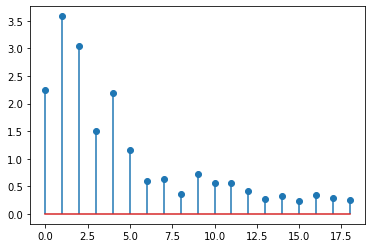

In [45]:
test_X = make_amplitude_df(data).iloc[:, 1:]
fft_plot(np.array(test_X)[10])

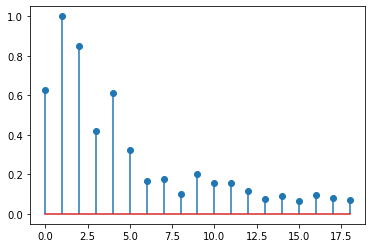

In [46]:
from sklearn.preprocessing import Normalizer
norm = Normalizer(norm='max')
test_X = norm.fit_transform(test_X)

fft_plot(test_X[10])

## 모델 불러오기

In [47]:
def plot_heatmap(actual, predicted, title):
    ax = plt.subplot()
    sns.heatmap(confusion_matrix(actual, predicted), annot=True, fmt='d', cbar=False, ax=ax)
    ax.set_xlabel("Predicted", fontsize=13)
    ax.set_ylabel("Actual", fontsize=13)
    ax.xaxis.set_ticklabels(["Normal", "Anomaly"])
    ax.yaxis.set_ticklabels(["Normal", "Anomaly"])
    ax.set_title(title, fontsize=15)
    plt.show()
    
def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='red', label='ROC')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

def plot_comp(proba, actual):
    threshold_arr = np.linspace(0, 1, 20)
    acc_arr = []
    rec_arr = []
    pre_arr = []
    for th in threshold_arr:
        predicted = (proba[:,1] >= th).astype('int')
        acc_arr.append(accuracy_score(actual, predicted))
        rec_arr.append(recall_score(actual, predicted))
        pre_arr.append(precision_score(actual, predicted))

    plt.plot(threshold_arr, acc_arr, 'g', label='accuracy score')
    plt.plot(threshold_arr, rec_arr, 'r', label='recall score')
    plt.plot(threshold_arr, pre_arr, 'b', label='precision score')
    # plt.axhline(y=0.9, color='k', linestyle='--')
    # plt.axvline(x=0.25, color='k', linestyle='--')
    plt.title("Precision and Recall score comparision", fontsize=20)
    plt.xlabel("Threshold", fontsize=15)
    plt.xticks(np.arange(0,1.1,.1))
    plt.ylabel("Score", fontsize=15)
    plt.legend()
    plt.show()
    
def plot_all(model, df_X, df_y, model_name):

    pred = model.predict(df_X)
    acc = accuracy_score(df_y, pred)
    rec = recall_score(df_y, pred)
    pre = precision_score(df_y, pred) 
    print("accuracy_score: {:.3f}, recall score: {:.3f}, f1 score: {:.3f}".format(acc, rec, pre))

    prob = model.predict_proba(df_X)[:,1]
    fper, tper, thresholds = roc_curve(df_y, prob)
    print('roc-auc score: ', round(roc_auc_score(df_y,prob),2))

    predicted_proba = model.predict_proba(df_X)

    plot_heatmap(df_y, pred, f"Confusion Matrix @{model_name}")
    plot_roc_curve(fper, tper)
    plot_comp(predicted_proba, df_y)

accuracy_score: 0.687, recall score: 0.000, f1 score: 0.000
roc-auc score:  0.94


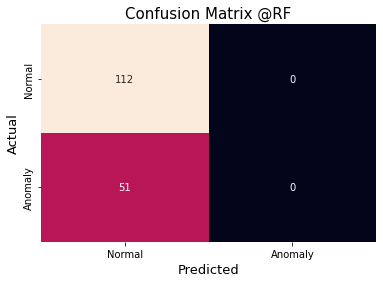

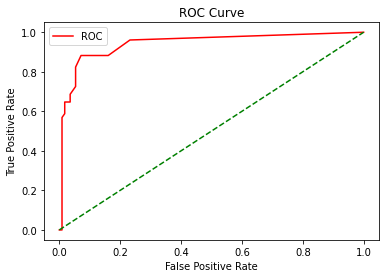

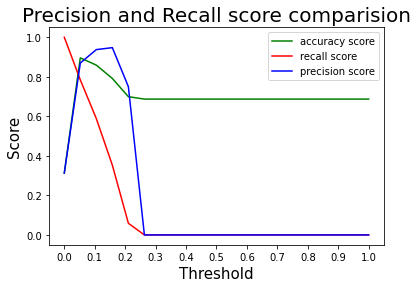

In [212]:
# RF
model = joblib.load("/home/seon/workspace/project/anomaly_wafer_detection/model/basic_rf.pkl")

plot_all(model, test_X, test_y, "RF")

accuracy_score: 0.871, recall score: 0.667, f1 score: 0.895
roc-auc score:  0.82


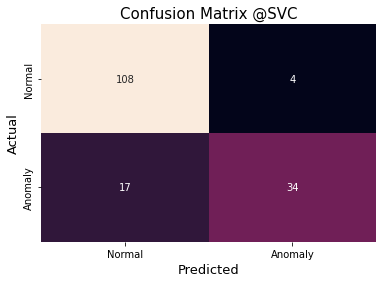

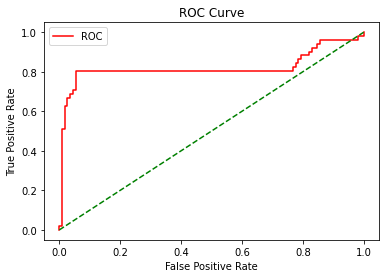

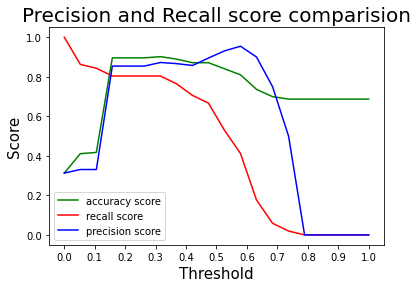

In [48]:
# SVC
model = joblib.load("/home/seon/workspace/project/anomaly_wafer_detection/model/basic_svc.pkl")

plot_all(model, test_X, test_y, "SVC")

accuracy_score: 0.687, recall score: 0.000, f1 score: 0.000
roc-auc score:  0.03


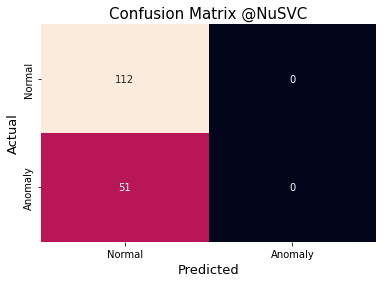

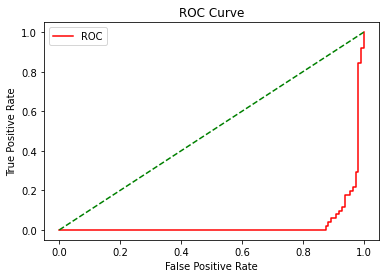

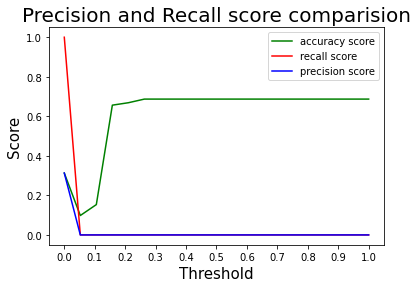

In [179]:
# NuSVC
model = joblib.load("/home/seon/workspace/project/anomaly_wafer_detection/model/linear_nusvc.pkl")

plot_all(model, test_X, test_y, "NuSVC")

accuracy_score: 0.902, recall score: 0.804, f1 score: 0.872
roc-auc score:  0.87


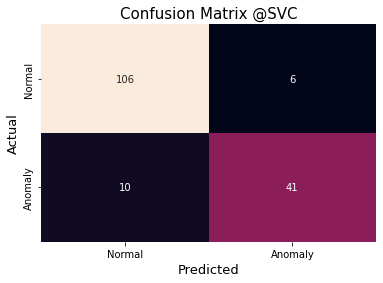

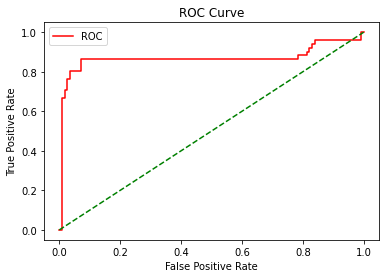

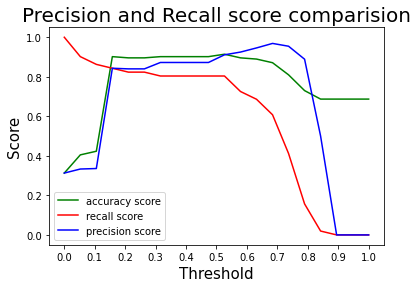

In [227]:
# SVC
model = joblib.load("/home/seon/workspace/project/anomaly_wafer_detection/model/tuned_svc.pkl")

plot_all(model, test_X, test_y, "SVC")

accuracy_score: 0.902, recall score: 0.804, f1 score: 0.872


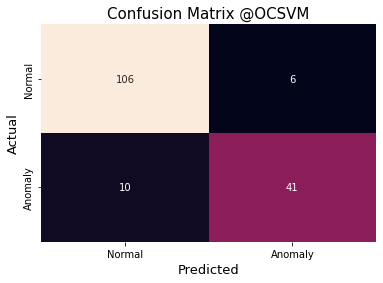

In [50]:
# OCSVM
model = joblib.load("/home/seon/workspace/project/anomaly_wafer_detection/model/basic_ocsvm.pkl")

pred = model.predict(test_X)
acc = accuracy_score(test_y, pred)
rec = recall_score(test_y, pred)
pre = precision_score(test_y, pred) 
print("accuracy_score: {:.3f}, recall score: {:.3f}, f1 score: {:.3f}".format(acc, rec, pre))
plot_heatmap(test_y, pred, "Confusion Matrix @OCSVM")

accuracy_score: 0.883, recall score: 0.667, f1 score: 0.944
roc-auc score:  0.84


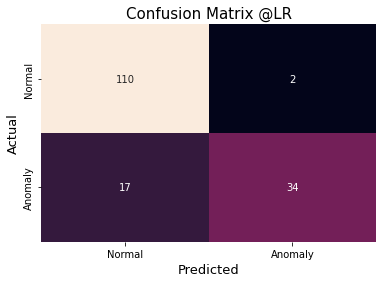

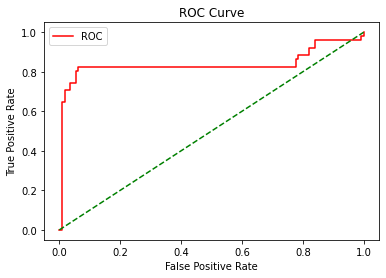

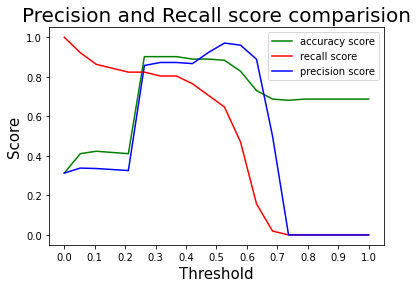

In [216]:
# Logistic Regression
model = joblib.load("/home/seon/workspace/project/anomaly_wafer_detection/model/basic_lr.pkl")

plot_all(model, test_X, test_y, "LR")